In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import time
import multiprocessing as mp
import dask.dataframe
from yahoo_finance import Share
from yahoofinancials import YahooFinancials

# for simfin package, refer to https://github.com/SimFin/simfin-tutorials
# type following clause in cmd to download simfin: git clone https://github.com/simfin/simfin-tutorials.git
# then use 'pip install simfin' to install this package
import seaborn as sns
import statsmodels.api as sm

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [3]:
# read SDG, SDG_adj, sentiment data file
t1=time.time()
data = dask.dataframe.read_csv("SDG_Data_File_Daily.csv")
SDG = data.compute()
del SDG['Unnamed: 0']
data = dask.dataframe.read_csv("SDG_Adjusted_File_Daily.csv")
SDG_adj = data.compute()
del SDG_adj['Unnamed: 0']
data = dask.dataframe.read_csv("Sentiment_Data_File_Daily.csv")
sentiment = data.compute()
del sentiment['Unnamed: 0']
time.time()-t1

75.01864790916443

In [4]:
# import simfin database to collect daily price, P/E and P/Book,etc
t2=time.time()

# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as Income Statements etc., 
# because the REPORT_DATE is not when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.) every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# Read dataset including following statistics: adj.close, P/E, P/Book
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

df_fin_signals = hub.fin_signals(variant='daily')
df_growth_signals = hub.growth_signals(variant='daily')
df_val_signals = hub.val_signals(variant='daily')
df_prices = hub.load_shareprices(variant='daily')

# Combine the DataFrames.
dfs = [df_prices, df_fin_signals, df_growth_signals, df_val_signals]
#dfs = [df_prices, df_val_signals]
print(time.time()-t2)
df_signals = pd.concat(dfs, axis=1)

Dataset "us-income-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (8 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-739b68a6.pickle' on disk (8 days old).
- Loading from disk ... Done!
60.76571607589722


In [5]:
df_signals.columns

Index(['SimFinId', 'Open', 'Low', 'High', 'Close', 'Adj. Close', 'Dividend',
       'Volume', '(Dividends + Share Buyback) / FCF', 'Asset Turnover',
       'CapEx / (Depr + Amor)', 'Current Ratio', 'Debt Ratio',
       'Dividends / FCF', 'Gross Profit Margin', 'Interest Coverage',
       'Inventory Turnover', 'Log Revenue', 'Net Acquisitions / Total Assets',
       'Net Profit Margin', 'Quick Ratio', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Assets', 'Return on Equity',
       'Return on Research Capital', 'Share Buyback / FCF', 'Assets Growth',
       'Assets Growth QOQ', 'Assets Growth YOY', 'Earnings Growth',
       'Earnings Growth QOQ', 'Earnings Growth YOY', 'FCF Growth',
       'FCF Growth QOQ', 'FCF Growth YOY', 'Sales Growth', 'Sales Growth QOQ',
       'Sales Growth YOY', 'Dividend Yield', 'Earnings Yield', 'FCF Yield',
       'Market-Cap', 'P/Book', 'P/Cash', 'P/E', 'P/FCF', 'P/NCAV', 'P/NetNet',
       'P/Sales'],
      dtype='object')

In [6]:
df_signals

SimFinId   Open      Low    High  Close  Adj. Close  \
Ticker Date                                                              
A      2007-01-03     45846  34.99  34.0500  35.480  34.30       22.85   
       2007-01-04     45846  34.30  33.4600  34.600  34.41       22.92   
       2007-01-05     45846  34.30  34.0000  34.400  34.09       22.71   
       2007-01-08     45846  33.98  33.6800  34.080  33.97       22.63   
       2007-01-09     45846  34.08  33.6300  34.320  34.01       22.65   
...                     ...    ...      ...     ...    ...         ...   
low    2019-06-03    186050  93.03  92.9000  95.060  93.84       91.92   
       2019-06-04    186050  95.01  95.0100  97.050  96.83       94.85   
       2019-06-05    186050  97.54  95.2900  97.540  96.25       94.28   
       2019-06-06    186050  96.30  95.1347  96.770  96.24       94.27   
       2019-06-07    186050  96.98  96.7000  97.615  96.76       94.78   

                   Dividend   Volume  (Dividends + Share Buyback) / FCF  \
Ticker Date                                                               
A      2007-01-03       NaN  2574600                                NaN   
       2007-01-04       NaN  2073700                                NaN   
       2007-01-05       NaN  2676600                                NaN   
       2007-01-08       NaN  1557200                                NaN   
       2007-01-09       NaN  1386200                                NaN   
...                     ...      ...                                ...   
low    2019-06-03       NaN  8393931                           0.859274   
       2019-06-04       NaN  5560500                           0.859274   
       2019-06-05       NaN  5137114                           0.859274   
       2019-06-06       NaN  4569636                           0.859274   
       2019-06-07       NaN  3974720                           0.859274   

                   Asset Turnover  ...  Earnings Yield  FCF Yield  \
Ticker Date                        ...                              
A      2007-01-03             NaN  ...             NaN        NaN   
       2007-01-04             NaN  ...             NaN        NaN   
       2007-01-05             NaN  ...             NaN        NaN   
       2007-01-08             NaN  ...             NaN        NaN   
       2007-01-09             NaN  ...             NaN        NaN   
...                           ...  ...             ...        ...   
low    2019-06-03        2.066448  ...        0.030368   0.066865   
       2019-06-04        2.066448  ...        0.029430   0.064800   
       2019-06-05        2.066448  ...        0.029608   0.065191   
       2019-06-06        2.066448  ...        0.029611   0.065198   
       2019-06-07        2.066448  ...        0.029452   0.064847   

                     Market-Cap     P/Book      P/Cash        P/E      P/FCF  \
Ticker Date                                                                    
A      2007-01-03           NaN        NaN         NaN        NaN        NaN   
       2007-01-04           NaN        NaN         NaN        NaN        NaN   
       2007-01-05           NaN        NaN         NaN        NaN        NaN   
       2007-01-08           NaN        NaN         NaN        NaN        NaN   
       2007-01-09           NaN        NaN         NaN        NaN        NaN   
...                         ...        ...         ...        ...        ...   
low    2019-06-03  7.619808e+10  20.910560  104.524115  32.929162  14.955462   
       2019-06-04  7.862596e+10  21.576828  107.854540  33.978375  15.431984   
       2019-06-05  7.815500e+10  21.447585  107.208505  33.774849  15.339549   
       2019-06-06  7.814688e+10  21.445357  107.197366  33.771340  15.337955   
       2019-06-07  7.856912e+10  21.561229  107.776571  33.953812  15.420828   

                     P/NCAV  P/NetNet   P/Sales  
Ticker Date                                      
A      2007-01-03       NaN       NaN    

In [7]:
# ticker in df_signals
mi = df_signals.index
ti = mi.get_level_values(0)
usti = set(list(ti))
# ticker in SDG, SDG_adj, sentiment
ticker1 = SDG["Ticker"]
ticker2 = SDG_adj["Ticker"]
ticker3 = sentiment["Ticker"]
tick = np.concatenate((ticker1,ticker2))
tickers = set(np.concatenate((tick,ticker3)))
# common tickers
ctickers=usti-(usti-tickers)
print('Collected P/E, P/Book data for %f percent of equities' % (len(ctickers)/len(tickers)))

Collected P/E, P/Book data for 0.911717 percent of equities


In [8]:
t3=time.time()
select_info = ['Adj. Close','Log Revenue','P/Book','P/E','P/Cash','P/FCF','P/Sales','Net Profit Margin',\
               'Return on Assets','Return on Equity','Assets Growth','Earnings Growth','FCF Growth','Sales Growth',\
               'Dividend Yield','Earnings Yield','FCF Yield']
df_basic = pd.DataFrame(columns = ['Timestamp','Ticker']+select_info)
for i in ctickers:
    newdf = df_signals.loc[i,select_info]
    newdf.insert(0,'Ticker',i)
    newdf.insert(0,'Timestamp',newdf.index)
    df_basic = df_basic.append(newdf,ignore_index=True)

# determine the start date in given data files (SDG, SDG_adj, sentiment)
start_date = min(min(SDG['Timestamp']),min(SDG_adj['Timestamp']),min(sentiment['Timestamp']))
end_date = max(max(SDG['Timestamp']),max(SDG_adj['Timestamp']),max(sentiment['Timestamp']))
df_fundinfo = df_basic[df_basic['Timestamp']>=start_date]
print(time.time()-t3)
df_fundinfo

645.6708889007568


,Timestamp,Ticker,Adj. Close,Log Revenue,P/Book,P/E,P/Cash,P/FCF,P/Sales,Net Profit Margin,Return on Assets,Return on Equity,Assets Growth,Earnings Growth,FCF Growth,Sales Growth,Dividend Yield,Earnings Yield,FCF Yield
1570,2013-04-01,ALV,41.42,9.917332,1.709538,13.362426,6.602627,19.675063,0.780891,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027512,0.074837,0.050826
1571,2013-04-02,ALV,41.84,9.917332,1.727167,13.500218,6.670712,19.877949,0.788943,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027231,0.074073,0.050307
1572,2013-04-03,ALV,41.87,9.917332,1.728425,13.510054,6.675572,19.892432,0.789518,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027211,0.074019,0.050270
1573,2013-04-04,ALV,41.36,9.917332,1.707273,13.344721,6.593878,19.648993,0.779856,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027548,0.074936,0.050893
1574,2013-04-05,ALV,41.48,9.917332,1.712307,13.384066,6.613319,19.706926,0.782155,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027467,0.074716,0.050744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654033,2019-06-03,FTI,20.41,10.091340,0.920976,-4.804736,1.931261,-24.178749,0.777046,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.208128,-0.041359
1654034,2019-06-04,FTI,20.72,10.091340,0.934956,-4.877673,1.960578,-24.545789,0.788842,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.205016,-0.040740
1654035,2019-06-05,FTI,20.78,10.091340,0.937578,-4.891349,1.966075,-24.614609,0.791054,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.204443,-0.040626
1654036,2019-06-06,FTI,21.63,10.091340,0.976025,-5.091926,2.046697,-25.623969,0.823492,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.196389,-0.039026


In [9]:
df_fundinfo

,Timestamp,Ticker,Adj. Close,Log Revenue,P/Book,P/E,P/Cash,P/FCF,P/Sales,Net Profit Margin,Return on Assets,Return on Equity,Assets Growth,Earnings Growth,FCF Growth,Sales Growth,Dividend Yield,Earnings Yield,FCF Yield
1570,2013-04-01,ALV,41.42,9.917332,1.709538,13.362426,6.602627,19.675063,0.780891,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027512,0.074837,0.050826
1571,2013-04-02,ALV,41.84,9.917332,1.727167,13.500218,6.670712,19.877949,0.788943,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027231,0.074073,0.050307
1572,2013-04-03,ALV,41.87,9.917332,1.728425,13.510054,6.675572,19.892432,0.789518,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027211,0.074019,0.050270
1573,2013-04-04,ALV,41.36,9.917332,1.707273,13.344721,6.593878,19.648993,0.779856,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027548,0.074936,0.050893
1574,2013-04-05,ALV,41.48,9.917332,1.712307,13.384066,6.613319,19.706926,0.782155,0.058439,0.073528,0.127936,0.074052,-0.225056,-0.182203,0.004166,0.027467,0.074716,0.050744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654033,2019-06-03,FTI,20.41,10.091340,0.920976,-4.804736,1.931261,-24.178749,0.777046,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.208128,-0.041359
1654034,2019-06-04,FTI,20.72,10.091340,0.934956,-4.877673,1.960578,-24.545789,0.788842,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.205016,-0.040740
1654035,2019-06-05,FTI,20.78,10.091340,0.937578,-4.891349,1.966075,-24.614609,0.791054,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.204443,-0.040626
1654036,2019-06-06,FTI,21.63,10.091340,0.976025,-5.091926,2.046697,-25.623969,0.823492,-0.161725,-0.077870,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.196389,-0.039026


In [10]:
df_basic

,Timestamp,Ticker,Adj. Close,Log Revenue,P/Book,P/E,P/Cash,P/FCF,P/Sales,Net Profit Margin,Return on Assets,Return on Equity,Assets Growth,Earnings Growth,FCF Growth,Sales Growth,Dividend Yield,Earnings Yield,FCF Yield
0,2007-01-03,ALV,31.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-04,ALV,31.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-05,ALV,30.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-08,ALV,31.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-09,ALV,31.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654033,2019-06-03,FTI,20.41,10.09134,0.920976,-4.804736,1.931261,-24.178749,0.777046,-0.161725,-0.07787,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.208128,-0.041359
1654034,2019-06-04,FTI,20.72,10.09134,0.934956,-4.877673,1.960578,-24.545789,0.788842,-0.161725,-0.07787,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.205016,-0.040740
1654035,2019-06-05,FTI,20.78,10.09134,0.937578,-4.891349,1.966075,-24.614609,0.791054,-0.161725,-0.07787,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.204443,-0.040626
1654036,2019-06-06,FTI,21.63,10.09134,0.976025,-5.091926,2.046697,-25.623969,0.823492,-0.161725,-0.07787,-0.191681,-0.101582,-9.788199,0.022692,-0.165836,NaN,-0.196389,-0.039026


In [41]:
# df_basic.to_csv('df_basic.csv')
# df_fundinfo.to_csv('appdata/df_fundinfo.csv')

# prediction

In [12]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
from matplotlib import pyplot
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import math
import datetime

Using TensorFlow backend.


## GARCH model

In [13]:
ticker_pre = 'AAPL'
col_pre = 'Adj. Close'
df_pre = df_fundinfo.loc[df_fundinfo['Ticker']==ticker_pre].loc[:,['Timestamp','Ticker',col_pre]]
df_pre = df_pre.set_index('Timestamp')
df_pre

,Ticker,Adj. Close
Timestamp,,
2013-04-01,AAPL,53.82
2013-04-02,AAPL,53.93
2013-04-03,AAPL,54.21
2013-04-04,AAPL,53.67
2013-04-05,AAPL,53.11
...,...,...
2019-06-03,AAPL,171.26
2019-06-04,AAPL,177.53
2019-06-05,AAPL,180.39


<function matplotlib.pyplot.show(*args, **kw)>

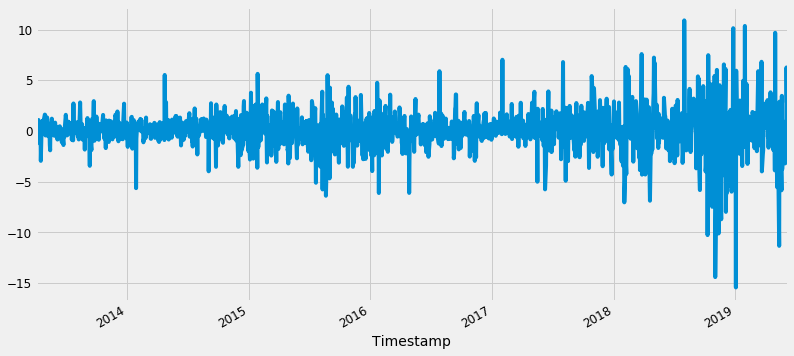

In [14]:
y = df_pre[col_pre].diff()[1:]
y.plot(figsize=(12,6))
plt.show

In [15]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
print(adf_test(y))

print('\nThe above results show there is no unit root in our data \nso we can use the data to analyze')

Results of Dickey-Fuller Test:
Test Statistic                -1.331043e+01
p-value                        6.763788e-25
#Lags Used                     7.000000e+00
Number of Observations Used    1.550000e+03
Critical Value (1%)           -3.434576e+00
Critical Value (5%)           -2.863406e+00
Critical Value (10%)          -2.567764e+00
dtype: float64
None

The above results show there is no unit root in our data 
so we can use the data to analyze


In [16]:
# use AIC to select best grach model, i.e. select optimal value p,d,q in GARCH(p,d,q)
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = arch_model(TS, p=i,o=d,q=j,dist='StudentsT')
                    tmp_res = tmp_mdl.fit(update_freq=5, disp='off')
                    tmp_aic = tmp_res.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order

TS = y
best_aic,best_order = _get_best_model(TS)

aic: 5791.28969 | order: (1, 1, 2)


In [17]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(y, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())
print('\nThe results above show that GARCH model with univariate does not fit \
our data well \nso we include more features and use neutral network to forecast stock price, see below for details')

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Adj. Close   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2888.64
Distribution:      Standardized Student's t   AIC:                           5791.29
Method:                  Maximum Likelihood   BIC:                           5828.75
                                              No. Observations:                 1558
Date:                      Tue, Jun 16 2020   Df Residuals:                     1551
Time:                              15:33:40   Df Model:                            7
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [18]:
fore = res.forecast(horizon=1)

In [19]:
print('An 1-day forecasted value is: ',fore.mean.iloc[-1].values[0])

An 1-day forecasted value is:  0.10031173315838235


## Neutral Network-LSTM

### without using SDG as risk factors

In [20]:
ticker_pre = 'AAL'
col_pre = ['Adj. Close','Log Revenue','P/Book','P/E','P/Cash','P/FCF','P/Sales','Net Profit Margin',\
               'Return on Assets','Return on Equity','Assets Growth','Earnings Growth','FCF Growth','Sales Growth',\
               'Dividend Yield','Earnings Yield','FCF Yield']
df_pred = df_basic.loc[df_basic['Ticker']==ticker_pre].loc[:,['Timestamp','Ticker']+col_pre]
df_pred.dropna(inplace=True)
df_pred

,Timestamp,Ticker,Adj. Close,Log Revenue,P/Book,P/E,P/Cash,P/FCF,P/Sales,Net Profit Margin,Return on Assets,Return on Equity,Assets Growth,Earnings Growth,FCF Growth,Sales Growth,Dividend Yield,Earnings Yield,FCF Yield
132200,2015-11-30,AAL,39.43,10.618268,7.759682,5.927294,3.289972,29.696770,0.703064,0.118615,0.101098,1.309144,0.102823,16.341549,-1.304901,0.041749,0.009523,0.168711,0.033674
132201,2015-12-01,AAL,41.34,10.618268,8.135818,6.214609,3.449447,31.136264,0.737144,0.118615,0.101098,1.309144,0.102823,16.341549,-1.304901,0.041749,0.009083,0.160911,0.032117
132202,2015-12-02,AAL,41.87,10.618268,8.241136,6.295057,3.494101,31.539322,0.746686,0.118615,0.101098,1.309144,0.102823,16.341549,-1.304901,0.041749,0.008967,0.158855,0.031706
132203,2015-12-03,AAL,41.35,10.618268,8.137699,6.216045,3.450245,31.143461,0.737314,0.118615,0.101098,1.309144,0.102823,16.341549,-1.304901,0.041749,0.009081,0.160874,0.032109
132204,2015-12-04,AAL,42.97,10.618268,8.457414,6.460262,3.585799,32.367032,0.766282,0.118615,0.101098,1.309144,0.102823,16.341549,-1.304901,0.041749,0.008738,0.154792,0.030896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133081,2019-06-03,AAL,26.92,10.650541,-19.688684,8.874559,2.879283,14.476304,0.279984,0.031549,0.023212,-2.218553,0.140897,-0.245858,3.458763,0.040480,0.014694,0.112682,0.069078
133082,2019-06-04,AAL,28.82,10.650541,-21.078473,9.500998,3.082527,15.498161,0.299748,0.031549,0.023212,-2.218553,0.140897,-0.245858,3.458763,0.040480,0.013725,0.105252,0.064524
133083,2019-06-05,AAL,30.05,10.650541,-21.976045,9.905574,3.213788,16.158110,0.312512,0.031549,0.023212,-2.218553,0.140897,-0.245858,3.458763,0.040480,0.013165,0.100953,0.061888
133084,2019-06-06,AAL,30.07,10.650541,-21.990522,9.912099,3.215905,16.168754,0.312717,0.031549,0.023212,-2.218553,0.140897,-0.245858,3.458763,0.040480,0.013156,0.100887,0.061848


In [22]:
# standardize and dropna
df_pre = df_pred.drop(columns=['Timestamp','Ticker'])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(df_pre.values)
df = pd.DataFrame(x_scaled)
df = pd.concat([df,pd.DataFrame(df_pre['Adj. Close'].shift(-1)).set_index(df.index)],axis=1)
df.dropna(inplace=True)
df

(886, 17)
(885, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,Adj. Close
0,0.462997,0.33102,0.991867,0.286840,0.286220,0.416161,0.845991,0.567737,0.581367,0.974065,0.721525,1.000000,0.431401,0.767477,0.285783,0.272392,0.453199,41.34
1,0.521407,0.33102,0.995466,0.309336,0.338108,0.419460,0.914136,0.567737,0.581367,0.974065,0.721525,1.000000,0.431401,0.767477,0.238004,0.251604,0.438313,41.87
2,0.537615,0.33102,0.996473,0.315636,0.352636,0.420383,0.933217,0.567737,0.581367,0.974065,0.721525,1.000000,0.431401,0.767477,0.225408,0.246123,0.434388,41.35
3,0.521713,0.33102,0.995484,0.309449,0.338367,0.419476,0.914477,0.567737,0.581367,0.974065,0.721525,1.000000,0.431401,0.767477,0.237776,0.251505,0.438242,42.97
4,0.571254,0.33102,0.998543,0.328571,0.382472,0.422280,0.972401,0.567737,0.581367,0.974065,0.721525,1.000000,0.431401,0.767477,0.200523,0.235296,0.426635,43.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.081346,1.00000,0.729058,0.518376,0.153628,0.381319,0.000617,0.006354,0.000000,0.618504,0.957920,0.026675,0.946714,0.756164,0.845182,0.122729,0.791013,26.92
881,0.080428,1.00000,0.729266,0.517610,0.152594,0.381283,0.000000,0.006354,0.000000,0.618504,0.957920,0.026675,0.946714,0.756164,0.846938,0.123060,0.791740,28.82
882,0.138532,1.00000,0.715969,0.566660,0.218723,0.383625,0.039519,0.006354,0.000000,0.618504,0.957920,0.026675,0.946714,0.756164,0.741799,0.103258,0.748189,30.05
883,0.176147,1.00000,0.707382,0.598338,0.261432,0.385137,0.065042,0.006354,0.000000,0.618504,0.957920,0.026675,0.946714,0.756164,0.680964,0.091801,0.722990,30.07


In [23]:
# divide data into train and test set
values=df.values
n_train = int(df.shape[0]*0.9)
train = values[:n_train,:]
test = values[n_train:,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(796, 1, 17) (796,) (89, 1, 17) (89,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 716 samples, validate on 80 samples
Epoch 1/2000
 - 1s - loss: 1808.9278 - val_loss: 1123.8005
Epoch 2/2000
 - 0s - loss: 1792.1230 - val_loss: 1111.2273
Epoch 3/2000
 - 0s - loss: 1773.7175 - val_loss: 1096.8779
Epoch 4/2000
 - 0s - loss: 1752.3804 - val_loss: 1080.0851
Epoch 5/2000
 - 0s - loss: 1727.0981 - val_loss: 1060.2955
Epoch 6/2000
 - 0s - loss: 1697.2156 - val_loss: 1037.1311
Epoch 7/2000
 - 0s - loss: 1662.3178 - val_loss: 1010.4063
Epoch 8/2000
 - 0s - loss: 1622.3017 - val_loss: 980.0979
Epoch 9/2000
 - 0s - loss: 1577.3310 - val_loss: 946.4367
Epoch 10/2000
 - 0s - loss: 1527.7710 - val_loss: 909.7078
Epoch 11/2000
 - 0s - loss: 1474.1670 - val_loss: 870.3688
Epoch 12/2000
 - 0s - loss: 1417.1051 - val_loss: 828.8604
Epoch 13/2000
 - 0s - loss: 1357.2068 - val_loss: 785.6650
Epoch 14/2000
 - 0s - loss: 1295.0901 - val_loss: 741.2329
Epoch 15/20

Epoch 135/2000
 - 0s - loss: 41.3530 - val_loss: 55.2961
Epoch 136/2000
 - 0s - loss: 41.2203 - val_loss: 55.9612
Epoch 137/2000
 - 0s - loss: 41.0957 - val_loss: 56.6109
Epoch 138/2000
 - 0s - loss: 40.9789 - val_loss: 57.2454
Epoch 139/2000
 - 0s - loss: 40.8694 - val_loss: 57.8647
Epoch 140/2000
 - 0s - loss: 40.7667 - val_loss: 58.4690
Epoch 141/2000
 - 0s - loss: 40.6704 - val_loss: 59.0584
Epoch 142/2000
 - 0s - loss: 40.5802 - val_loss: 59.6330
Epoch 143/2000
 - 0s - loss: 40.4957 - val_loss: 60.1929
Epoch 144/2000
 - 0s - loss: 40.4166 - val_loss: 60.7382
Epoch 145/2000
 - 0s - loss: 40.3425 - val_loss: 61.2693
Epoch 146/2000
 - 0s - loss: 40.2731 - val_loss: 61.7862
Epoch 147/2000
 - 0s - loss: 40.2082 - val_loss: 62.2890
Epoch 148/2000
 - 0s - loss: 40.1474 - val_loss: 62.7781
Epoch 149/2000
 - 0s - loss: 40.0905 - val_loss: 63.2537
Epoch 150/2000
 - 0s - loss: 40.0373 - val_loss: 63.7158
Epoch 151/2000
 - 0s - loss: 39.9875 - val_loss: 64.1648
Epoch 152/2000
 - 0s - loss: 39

Epoch 279/2000
 - 0s - loss: 18.3451 - val_loss: 81.3693
Epoch 280/2000
 - 0s - loss: 18.0390 - val_loss: 81.3499
Epoch 281/2000
 - 0s - loss: 17.7490 - val_loss: 81.3437
Epoch 282/2000
 - 0s - loss: 17.4806 - val_loss: 81.3382
Epoch 283/2000
 - 0s - loss: 17.2364 - val_loss: 81.3181
Epoch 284/2000
 - 0s - loss: 17.0142 - val_loss: 81.2644
Epoch 285/2000
 - 0s - loss: 16.8084 - val_loss: 81.1571
Epoch 286/2000
 - 0s - loss: 16.6138 - val_loss: 80.9798
Epoch 287/2000
 - 0s - loss: 16.4257 - val_loss: 80.7231
Epoch 288/2000
 - 0s - loss: 16.2408 - val_loss: 80.3848
Epoch 289/2000
 - 0s - loss: 16.0565 - val_loss: 79.9684
Epoch 290/2000
 - 0s - loss: 15.8707 - val_loss: 79.4812
Epoch 291/2000
 - 0s - loss: 15.6821 - val_loss: 78.9333
Epoch 292/2000
 - 0s - loss: 15.4900 - val_loss: 78.3344
Epoch 293/2000
 - 0s - loss: 15.2952 - val_loss: 77.6947
Epoch 294/2000
 - 0s - loss: 15.0992 - val_loss: 77.0241
Epoch 295/2000
 - 0s - loss: 14.9044 - val_loss: 76.3295
Epoch 296/2000
 - 0s - loss: 14

Epoch 426/2000
 - 0s - loss: 2.3360 - val_loss: 1.9085
Epoch 427/2000
 - 0s - loss: 2.3114 - val_loss: 1.9021
Epoch 428/2000
 - 0s - loss: 2.2871 - val_loss: 1.8965
Epoch 429/2000
 - 0s - loss: 2.2633 - val_loss: 1.8915
Epoch 430/2000
 - 0s - loss: 2.2398 - val_loss: 1.8870
Epoch 431/2000
 - 0s - loss: 2.2168 - val_loss: 1.8830
Epoch 432/2000
 - 0s - loss: 2.1941 - val_loss: 1.8797
Epoch 433/2000
 - 0s - loss: 2.1719 - val_loss: 1.8768
Epoch 434/2000
 - 0s - loss: 2.1500 - val_loss: 1.8744
Epoch 435/2000
 - 0s - loss: 2.1284 - val_loss: 1.8728
Epoch 436/2000
 - 0s - loss: 2.1073 - val_loss: 1.8718
Epoch 437/2000
 - 0s - loss: 2.0865 - val_loss: 1.8712
Epoch 438/2000
 - 0s - loss: 2.0661 - val_loss: 1.8704
Epoch 439/2000
 - 0s - loss: 2.0460 - val_loss: 1.8695
Epoch 440/2000
 - 0s - loss: 2.0263 - val_loss: 1.8687
Epoch 441/2000
 - 0s - loss: 2.0069 - val_loss: 1.8679
Epoch 442/2000
 - 0s - loss: 1.9879 - val_loss: 1.8674
Epoch 443/2000
 - 0s - loss: 1.9693 - val_loss: 1.8668
Epoch 444/

Epoch 575/2000
 - 0s - loss: 0.9981 - val_loss: 2.5823
Epoch 576/2000
 - 0s - loss: 0.9956 - val_loss: 2.5881
Epoch 577/2000
 - 0s - loss: 0.9932 - val_loss: 2.5936
Epoch 578/2000
 - 0s - loss: 0.9908 - val_loss: 2.5987
Epoch 579/2000
 - 0s - loss: 0.9885 - val_loss: 2.6037
Epoch 580/2000
 - 0s - loss: 0.9862 - val_loss: 2.6093
Epoch 581/2000
 - 0s - loss: 0.9839 - val_loss: 2.6146
Epoch 582/2000
 - 0s - loss: 0.9816 - val_loss: 2.6193
Epoch 583/2000
 - 0s - loss: 0.9793 - val_loss: 2.6246
Epoch 584/2000
 - 0s - loss: 0.9771 - val_loss: 2.6301
Epoch 585/2000
 - 0s - loss: 0.9749 - val_loss: 2.6345
Epoch 586/2000
 - 0s - loss: 0.9728 - val_loss: 2.6395
Epoch 587/2000
 - 0s - loss: 0.9706 - val_loss: 2.6447
Epoch 588/2000
 - 0s - loss: 0.9685 - val_loss: 2.6496
Epoch 589/2000
 - 0s - loss: 0.9664 - val_loss: 2.6545
Epoch 590/2000
 - 0s - loss: 0.9643 - val_loss: 2.6588
Epoch 591/2000
 - 0s - loss: 0.9622 - val_loss: 2.6639
Epoch 592/2000
 - 0s - loss: 0.9602 - val_loss: 2.6687
Epoch 593/

Epoch 724/2000
 - 0s - loss: 0.8012 - val_loss: 2.8245
Epoch 725/2000
 - 0s - loss: 0.8005 - val_loss: 2.8226
Epoch 726/2000
 - 0s - loss: 0.7998 - val_loss: 2.8220
Epoch 727/2000
 - 0s - loss: 0.7991 - val_loss: 2.8215
Epoch 728/2000
 - 0s - loss: 0.7984 - val_loss: 2.8213
Epoch 729/2000
 - 0s - loss: 0.7977 - val_loss: 2.8186
Epoch 730/2000
 - 0s - loss: 0.7971 - val_loss: 2.8168
Epoch 731/2000
 - 0s - loss: 0.7964 - val_loss: 2.8158
Epoch 732/2000
 - 0s - loss: 0.7957 - val_loss: 2.8159
Epoch 733/2000
 - 0s - loss: 0.7950 - val_loss: 2.8138
Epoch 734/2000
 - 0s - loss: 0.7944 - val_loss: 2.8110
Epoch 735/2000
 - 0s - loss: 0.7937 - val_loss: 2.8098
Epoch 736/2000
 - 0s - loss: 0.7931 - val_loss: 2.8109
Epoch 737/2000
 - 0s - loss: 0.7925 - val_loss: 2.8072
Epoch 738/2000
 - 0s - loss: 0.7918 - val_loss: 2.8078
Epoch 739/2000
 - 0s - loss: 0.7912 - val_loss: 2.8072
Epoch 740/2000
 - 0s - loss: 0.7906 - val_loss: 2.8050
Epoch 741/2000
 - 0s - loss: 0.7900 - val_loss: 2.8026
Epoch 742/

Epoch 873/2000
 - 0s - loss: 0.7385 - val_loss: 2.5117
Epoch 874/2000
 - 0s - loss: 0.7394 - val_loss: 2.5089
Epoch 875/2000
 - 0s - loss: 0.7385 - val_loss: 2.4363
Epoch 876/2000
 - 0s - loss: 0.7388 - val_loss: 2.5624
Epoch 877/2000
 - 0s - loss: 0.7391 - val_loss: 2.4052
Epoch 878/2000
 - 0s - loss: 0.7380 - val_loss: 2.5453
Epoch 879/2000
 - 0s - loss: 0.7388 - val_loss: 2.4515
Epoch 880/2000
 - 0s - loss: 0.7375 - val_loss: 2.4581
Epoch 881/2000
 - 0s - loss: 0.7384 - val_loss: 2.5411
Epoch 882/2000
 - 0s - loss: 0.7382 - val_loss: 2.3748
Epoch 883/2000
 - 0s - loss: 0.7380 - val_loss: 2.5749
Epoch 884/2000
 - 0s - loss: 0.7391 - val_loss: 2.3910
Epoch 885/2000
 - 0s - loss: 0.7371 - val_loss: 2.4903
Epoch 886/2000
 - 0s - loss: 0.7388 - val_loss: 2.5035
Epoch 887/2000
 - 0s - loss: 0.7375 - val_loss: 2.3650
Epoch 888/2000
 - 0s - loss: 0.7384 - val_loss: 2.5948
Epoch 889/2000
 - 0s - loss: 0.7398 - val_loss: 2.3317
Epoch 890/2000
 - 0s - loss: 0.7377 - val_loss: 2.5268
Epoch 891/

Epoch 1022/2000
 - 0s - loss: 0.7288 - val_loss: 2.1695
Epoch 1023/2000
 - 0s - loss: 0.7233 - val_loss: 2.3423
Epoch 1024/2000
 - 0s - loss: 0.7247 - val_loss: 2.4117
Epoch 1025/2000
 - 0s - loss: 0.7245 - val_loss: 2.1310
Epoch 1026/2000
 - 0s - loss: 0.7272 - val_loss: 2.5394
Epoch 1027/2000
 - 0s - loss: 0.7289 - val_loss: 2.1529
Epoch 1028/2000
 - 0s - loss: 0.7231 - val_loss: 2.3601
Epoch 1029/2000
 - 0s - loss: 0.7242 - val_loss: 2.3873
Epoch 1030/2000
 - 0s - loss: 0.7233 - val_loss: 2.1411
Epoch 1031/2000
 - 0s - loss: 0.7264 - val_loss: 2.5376
Epoch 1032/2000
 - 0s - loss: 0.7283 - val_loss: 2.1402
Epoch 1033/2000
 - 0s - loss: 0.7231 - val_loss: 2.3772
Epoch 1034/2000
 - 0s - loss: 0.7238 - val_loss: 2.3629
Epoch 1035/2000
 - 0s - loss: 0.7223 - val_loss: 2.1518
Epoch 1036/2000
 - 0s - loss: 0.7256 - val_loss: 2.5354
Epoch 1037/2000
 - 0s - loss: 0.7278 - val_loss: 2.1314
Epoch 1038/2000
 - 0s - loss: 0.7233 - val_loss: 2.3912
Epoch 1039/2000
 - 0s - loss: 0.7240 - val_loss:

Epoch 1169/2000
 - 0s - loss: 0.7186 - val_loss: 2.4914
Epoch 1170/2000
 - 0s - loss: 0.7198 - val_loss: 2.1343
Epoch 1171/2000
 - 0s - loss: 0.7221 - val_loss: 2.5953
Epoch 1172/2000
 - 0s - loss: 0.7233 - val_loss: 2.2164
Epoch 1173/2000
 - 0s - loss: 0.7166 - val_loss: 2.3460
Epoch 1174/2000
 - 0s - loss: 0.7180 - val_loss: 2.5032
Epoch 1175/2000
 - 0s - loss: 0.7195 - val_loss: 2.1397
Epoch 1176/2000
 - 0s - loss: 0.7213 - val_loss: 2.5853
Epoch 1177/2000
 - 0s - loss: 0.7221 - val_loss: 2.2287
Epoch 1178/2000
 - 0s - loss: 0.7155 - val_loss: 2.3373
Epoch 1179/2000
 - 0s - loss: 0.7173 - val_loss: 2.5097
Epoch 1180/2000
 - 0s - loss: 0.7189 - val_loss: 2.1447
Epoch 1181/2000
 - 0s - loss: 0.7201 - val_loss: 2.5770
Epoch 1182/2000
 - 0s - loss: 0.7206 - val_loss: 2.2485
Epoch 1183/2000
 - 0s - loss: 0.7144 - val_loss: 2.3355
Epoch 1184/2000
 - 0s - loss: 0.7163 - val_loss: 2.5145
Epoch 1185/2000
 - 0s - loss: 0.7179 - val_loss: 2.1527
Epoch 1186/2000
 - 0s - loss: 0.7187 - val_loss:

Epoch 1316/2000
 - 0s - loss: 0.7138 - val_loss: 2.2773
Epoch 1317/2000
 - 0s - loss: 0.7181 - val_loss: 2.7274
Epoch 1318/2000
 - 0s - loss: 0.7213 - val_loss: 2.2488
Epoch 1319/2000
 - 0s - loss: 0.7158 - val_loss: 2.5582
Epoch 1320/2000
 - 0s - loss: 0.7159 - val_loss: 2.5306
Epoch 1321/2000
 - 0s - loss: 0.7145 - val_loss: 2.2694
Epoch 1322/2000
 - 0s - loss: 0.7187 - val_loss: 2.7374
Epoch 1323/2000
 - 0s - loss: 0.7213 - val_loss: 2.2629
Epoch 1324/2000
 - 0s - loss: 0.7149 - val_loss: 2.5451
Epoch 1325/2000
 - 0s - loss: 0.7149 - val_loss: 2.5460
Epoch 1326/2000
 - 0s - loss: 0.7140 - val_loss: 2.2695
Epoch 1327/2000
 - 0s - loss: 0.7176 - val_loss: 2.7260
Epoch 1328/2000
 - 0s - loss: 0.7197 - val_loss: 2.2827
Epoch 1329/2000
 - 0s - loss: 0.7133 - val_loss: 2.5335
Epoch 1330/2000
 - 0s - loss: 0.7137 - val_loss: 2.5602
Epoch 1331/2000
 - 0s - loss: 0.7131 - val_loss: 2.2777
Epoch 1332/2000
 - 0s - loss: 0.7163 - val_loss: 2.7159
Epoch 1333/2000
 - 0s - loss: 0.7180 - val_loss:

Epoch 1463/2000
 - 0s - loss: 0.7162 - val_loss: 2.8431
Epoch 1464/2000
 - 0s - loss: 0.7191 - val_loss: 2.3737
Epoch 1465/2000
 - 0s - loss: 0.7127 - val_loss: 2.6531
Epoch 1466/2000
 - 0s - loss: 0.7123 - val_loss: 2.6635
Epoch 1467/2000
 - 0s - loss: 0.7121 - val_loss: 2.3720
Epoch 1468/2000
 - 0s - loss: 0.7155 - val_loss: 2.8392
Epoch 1469/2000
 - 0s - loss: 0.7180 - val_loss: 2.3977
Epoch 1470/2000
 - 0s - loss: 0.7114 - val_loss: 2.6322
Epoch 1471/2000
 - 0s - loss: 0.7114 - val_loss: 2.6820
Epoch 1472/2000
 - 0s - loss: 0.7118 - val_loss: 2.3726
Epoch 1473/2000
 - 0s - loss: 0.7146 - val_loss: 2.8333
Epoch 1474/2000
 - 0s - loss: 0.7167 - val_loss: 2.4246
Epoch 1475/2000
 - 0s - loss: 0.7103 - val_loss: 2.6150
Epoch 1476/2000
 - 0s - loss: 0.7108 - val_loss: 2.7072
Epoch 1477/2000
 - 0s - loss: 0.7117 - val_loss: 2.3728
Epoch 1478/2000
 - 0s - loss: 0.7140 - val_loss: 2.8281
Epoch 1479/2000
 - 0s - loss: 0.7157 - val_loss: 2.4466
Epoch 1480/2000
 - 0s - loss: 0.7096 - val_loss:

Epoch 1610/2000
 - 0s - loss: 0.7148 - val_loss: 2.5100
Epoch 1611/2000
 - 0s - loss: 0.7087 - val_loss: 2.7335
Epoch 1612/2000
 - 0s - loss: 0.7087 - val_loss: 2.7817
Epoch 1613/2000
 - 0s - loss: 0.7090 - val_loss: 2.4842
Epoch 1614/2000
 - 0s - loss: 0.7112 - val_loss: 2.9140
Epoch 1615/2000
 - 0s - loss: 0.7130 - val_loss: 2.5342
Epoch 1616/2000
 - 0s - loss: 0.7074 - val_loss: 2.7117
Epoch 1617/2000
 - 0s - loss: 0.7081 - val_loss: 2.8030
Epoch 1618/2000
 - 0s - loss: 0.7088 - val_loss: 2.4876
Epoch 1619/2000
 - 0s - loss: 0.7106 - val_loss: 2.9086
Epoch 1620/2000
 - 0s - loss: 0.7122 - val_loss: 2.5583
Epoch 1621/2000
 - 0s - loss: 0.7068 - val_loss: 2.6931
Epoch 1622/2000
 - 0s - loss: 0.7081 - val_loss: 2.8266
Epoch 1623/2000
 - 0s - loss: 0.7094 - val_loss: 2.4790
Epoch 1624/2000
 - 0s - loss: 0.7109 - val_loss: 2.9103
Epoch 1625/2000
 - 0s - loss: 0.7124 - val_loss: 2.5750
Epoch 1626/2000
 - 0s - loss: 0.7071 - val_loss: 2.6701
Epoch 1627/2000
 - 0s - loss: 0.7090 - val_loss:

Epoch 1757/2000
 - 0s - loss: 0.7060 - val_loss: 2.8143
Epoch 1758/2000
 - 0s - loss: 0.7062 - val_loss: 2.8840
Epoch 1759/2000
 - 0s - loss: 0.7064 - val_loss: 2.6007
Epoch 1760/2000
 - 0s - loss: 0.7078 - val_loss: 2.9862
Epoch 1761/2000
 - 0s - loss: 0.7089 - val_loss: 2.6610
Epoch 1762/2000
 - 0s - loss: 0.7043 - val_loss: 2.7952
Epoch 1763/2000
 - 0s - loss: 0.7052 - val_loss: 2.8916
Epoch 1764/2000
 - 0s - loss: 0.7058 - val_loss: 2.6043
Epoch 1765/2000
 - 0s - loss: 0.7068 - val_loss: 2.9747
Epoch 1766/2000
 - 0s - loss: 0.7079 - val_loss: 2.6832
Epoch 1767/2000
 - 0s - loss: 0.7039 - val_loss: 2.7799
Epoch 1768/2000
 - 0s - loss: 0.7053 - val_loss: 2.9168
Epoch 1769/2000
 - 0s - loss: 0.7065 - val_loss: 2.5951
Epoch 1770/2000
 - 0s - loss: 0.7074 - val_loss: 2.9804
Epoch 1771/2000
 - 0s - loss: 0.7087 - val_loss: 2.6928
Epoch 1772/2000
 - 0s - loss: 0.7045 - val_loss: 2.7630
Epoch 1773/2000
 - 0s - loss: 0.7066 - val_loss: 2.9489
Epoch 1774/2000
 - 0s - loss: 0.7085 - val_loss:

Epoch 1904/2000
 - 0s - loss: 0.7073 - val_loss: 2.9141
Epoch 1905/2000
 - 0s - loss: 0.7053 - val_loss: 2.7150
Epoch 1906/2000
 - 0s - loss: 0.7078 - val_loss: 3.0957
Epoch 1907/2000
 - 0s - loss: 0.7093 - val_loss: 2.7047
Epoch 1908/2000
 - 0s - loss: 0.7049 - val_loss: 2.9610
Epoch 1909/2000
 - 0s - loss: 0.7045 - val_loss: 2.9216
Epoch 1910/2000
 - 0s - loss: 0.7033 - val_loss: 2.7369
Epoch 1911/2000
 - 0s - loss: 0.7051 - val_loss: 3.0674
Epoch 1912/2000
 - 0s - loss: 0.7064 - val_loss: 2.7317
Epoch 1913/2000
 - 0s - loss: 0.7031 - val_loss: 2.9397
Epoch 1914/2000
 - 0s - loss: 0.7034 - val_loss: 2.9287
Epoch 1915/2000
 - 0s - loss: 0.7026 - val_loss: 2.7385
Epoch 1916/2000
 - 0s - loss: 0.7042 - val_loss: 3.0578
Epoch 1917/2000
 - 0s - loss: 0.7055 - val_loss: 2.7478
Epoch 1918/2000
 - 0s - loss: 0.7025 - val_loss: 2.9262
Epoch 1919/2000
 - 0s - loss: 0.7032 - val_loss: 2.9490
Epoch 1920/2000
 - 0s - loss: 0.7030 - val_loss: 2.7282
Epoch 1921/2000
 - 0s - loss: 0.7046 - val_loss:

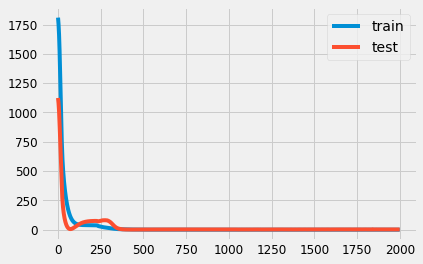

In [24]:
# design network
# We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting adj close
# The input shape will be 1 time step with 17 features.
model = Sequential()
model.add(LSTM(output_dim=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=72, validation_split=0.1, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.117


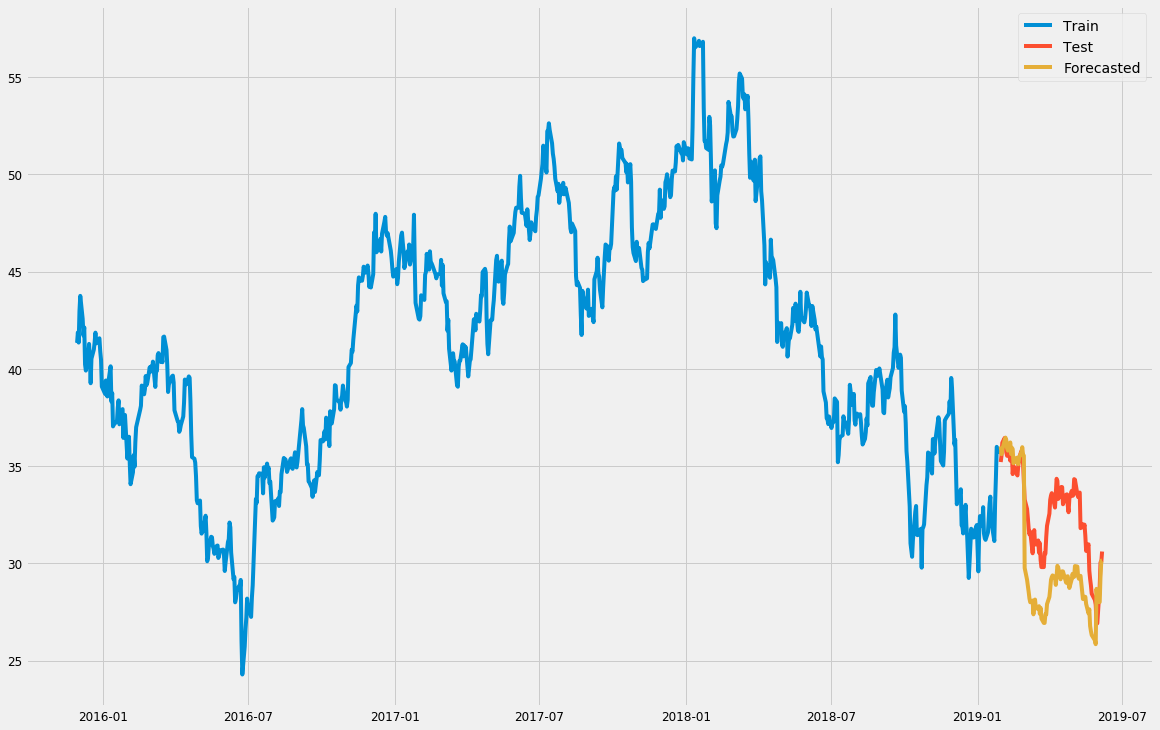

In [26]:
# show prediction vs actual value graph
df_res = pd.DataFrame({'date':df_pred['Timestamp'][:-1],
                       'actual':np.append(train_y,test_y),
                       'model':np.append(train_y,yhat)})
df_res = df_res.set_index('date')

fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df_res['actual'][:n_train],label='Train')
plt.plot(df_res['actual'][n_train:],label='Test')
plt.plot(df_res['model'][n_train:],label='Forecasted')
plt.legend()
plt.show()

In [193]:
# df_res.to_csv("appdata/df_res.csv")

### with using SDG as risk factors

In [137]:
ticker_pres = 'AAL'
col_sdgpre = ['SDG_Mean','STS_Mean','LTS_Mean','SDG_STD_Mean','SDG_News_Volume_Mean']
col_pres = ['Adj. Close','Log Revenue','P/Book','P/E','P/Cash','P/FCF','P/Sales','Net Profit Margin',\
               'Return on Assets','Return on Equity','Assets Growth','Earnings Growth','FCF Growth','Sales Growth',\
               'Dividend Yield','Earnings Yield','FCF Yield']
# read stock fundamental info
df_preds1 = df_basic.loc[df_basic['Ticker']==ticker_pres].loc[:,['Timestamp','Ticker']+col_pres]
# read stock SDG info, change df timestamp column to datetime64[ns] for later merge
df_preds2 = SDG.loc[SDG['Ticker']==ticker_pres].loc[:,['Timestamp']+col_sdgpre]
df_preds2['Timestamp'] = pd.to_datetime(df_preds2['Timestamp'])
# merge two dfs, the resulted df contains stock fundamental info and SDG info
df_preds = pd.merge(df_preds1,df_preds2,on='Timestamp')
df_preds.dropna(inplace=True)
df_preds

,Timestamp,Ticker,Adj. Close,Log Revenue,P/Book,P/E,P/Cash,P/FCF,P/Sales,Net Profit Margin,...,FCF Growth,Sales Growth,Dividend Yield,Earnings Yield,FCF Yield,SDG_Mean,STS_Mean,LTS_Mean,SDG_STD_Mean,SDG_News_Volume_Mean
673,2015-11-30,AAL,39.43,10.618268,7.759682,5.927294,3.289972,29.696770,0.703064,0.118615,...,-1.304901,0.041749,0.009523,0.168711,0.033674,-1.298321,-1.145664,-1.009298,2.431517,39.705882
674,2015-12-01,AAL,41.34,10.618268,8.135818,6.214609,3.449447,31.136264,0.737144,0.118615,...,-1.304901,0.041749,0.009083,0.160911,0.032117,-1.956827,-1.560329,-1.078411,2.558981,68.470588
675,2015-12-02,AAL,41.87,10.618268,8.241136,6.295057,3.494101,31.539322,0.746686,0.118615,...,-1.304901,0.041749,0.008967,0.158855,0.031706,-0.893553,-1.571956,-1.097500,2.530644,61.882353
676,2015-12-03,AAL,41.35,10.618268,8.137699,6.216045,3.450245,31.143461,0.737314,0.118615,...,-1.304901,0.041749,0.009081,0.160874,0.032109,-0.581551,-1.321845,-1.090298,3.028375,25.176471
677,2015-12-04,AAL,42.97,10.618268,8.457414,6.460262,3.585799,32.367032,0.766282,0.118615,...,-1.304901,0.041749,0.008738,0.154792,0.030896,-0.213563,-0.961230,-1.062647,2.198940,20.125000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,2019-06-03,AAL,26.92,10.650541,-19.688684,8.874559,2.879283,14.476304,0.279984,0.031549,...,3.458763,0.040480,0.014694,0.112682,0.069078,0.578061,0.122437,-1.700001,2.217529,30.588235
1555,2019-06-04,AAL,28.82,10.650541,-21.078473,9.500998,3.082527,15.498161,0.299748,0.031549,...,3.458763,0.040480,0.013725,0.105252,0.064524,-0.132616,0.130218,-1.644568,2.733534,27.937500
1556,2019-06-05,AAL,30.05,10.650541,-21.976045,9.905574,3.213788,16.158110,0.312512,0.031549,...,3.458763,0.040480,0.013165,0.100953,0.061888,-1.340861,-0.117790,-1.618025,3.379755,24.312500
1557,2019-06-06,AAL,30.07,10.650541,-21.990522,9.912099,3.215905,16.168754,0.312717,0.031549,...,3.458763,0.040480,0.013156,0.100887,0.061848,-1.330653,-0.462940,-1.604545,2.652099,18.133333


In [138]:
# standardize and dropna
df_pres = df_preds.drop(columns=['Timestamp','Ticker'])
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaleds = min_max_scaler.fit_transform(df_pres.values)
dfs = pd.DataFrame(x_scaleds)
dfs = pd.concat([dfs,pd.DataFrame(df_pres['Adj. Close'].shift(-1)).set_index(dfs.index)],axis=1)
dfs.dropna(inplace=True)
dfs

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,Adj. Close
0,0.462997,0.33102,0.991867,0.286840,0.286220,0.416161,0.845991,0.567737,0.581367,0.974065,...,0.767477,0.285783,0.272392,0.453199,0.516427,0.707835,0.921478,0.522928,0.051616,41.34
1,0.521407,0.33102,0.995466,0.309336,0.338108,0.419460,0.914136,0.567737,0.581367,0.974065,...,0.767477,0.238004,0.251604,0.438313,0.420799,0.638365,0.900151,0.572994,0.096131,41.87
2,0.537615,0.33102,0.996473,0.315636,0.352636,0.420383,0.933217,0.567737,0.581367,0.974065,...,0.767477,0.225408,0.246123,0.434388,0.575207,0.636417,0.894260,0.561864,0.085935,41.35
3,0.521713,0.33102,0.995484,0.309449,0.338367,0.419476,0.914477,0.567737,0.581367,0.974065,...,0.767477,0.237776,0.251505,0.438242,0.620516,0.678319,0.896483,0.757367,0.029131,42.97
4,0.571254,0.33102,0.998543,0.328571,0.382472,0.422280,0.972401,0.567737,0.581367,0.974065,...,0.767477,0.200523,0.235296,0.426635,0.673955,0.738734,0.905015,0.431575,0.021313,43.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0.081346,1.00000,0.729058,0.518376,0.153628,0.381319,0.000617,0.006354,0.000000,0.618504,...,0.756164,0.845182,0.122729,0.791013,0.774545,0.825798,0.641304,0.398803,0.022087,26.92
881,0.080428,1.00000,0.729266,0.517610,0.152594,0.381283,0.000000,0.006354,0.000000,0.618504,...,0.756164,0.846938,0.123060,0.791740,0.788915,0.920284,0.708340,0.438876,0.037506,28.82
882,0.138532,1.00000,0.715969,0.566660,0.218723,0.383625,0.039519,0.006354,0.000000,0.618504,...,0.756164,0.741799,0.103258,0.748189,0.685711,0.921588,0.725445,0.641557,0.033404,30.05
883,0.176147,1.00000,0.707382,0.598338,0.261432,0.385137,0.065042,0.006354,0.000000,0.618504,...,0.756164,0.680964,0.091801,0.722990,0.510249,0.880038,0.733636,0.895384,0.027794,30.07


In [139]:
# divide data into train and test set
values=dfs.values
n_train = int(dfs.shape[0]*0.9)
train = values[:n_train,:]
test = values[n_train:,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(796, 1, 22) (796,) (89, 1, 22) (89,)


Train on 716 samples, validate on 80 samples
Epoch 1/2000
 - 2s - loss: 1812.2945 - val_loss: 1126.0323
Epoch 2/2000
 - 0s - loss: 1787.8074 - val_loss: 1106.9895
Epoch 3/2000
 - 0s - loss: 1761.5617 - val_loss: 1085.7528
Epoch 4/2000
 - 0s - loss: 1731.5345 - val_loss: 1061.0271
Epoch 5/2000
 - 0s - loss: 1696.2690 - val_loss: 1032.0039
Epoch 6/2000
 - 0s - loss: 1654.9601 - val_loss: 998.3161
Epoch 7/2000
 - 0s - loss: 1607.3565 - val_loss: 959.9612
Epoch 8/2000
 - 0s - loss: 1553.7451 - val_loss: 917.3331
Epoch 9/2000
 - 0s - loss: 1494.6206 - val_loss: 871.0217
Epoch 10/2000
 - 0s - loss: 1430.7963 - val_loss: 821.6812
Epoch 11/2000
 - 0s - loss: 1363.1885 - val_loss: 770.1001
Epoch 12/2000
 - 0s - loss: 1292.6482 - val_loss: 717.0089
Epoch 13/2000
 - 0s - loss: 1220.0273 - val_loss: 663.0413
Epoch 14/2000
 - 0s - loss: 1146.2815 - val_loss: 608.9082
Epoch 15/2000
 - 0s - loss: 1072.5184 - val_loss: 555.3290
Epoch 16/2000
 - 0s - loss: 1000.3515 - val_loss: 503.4132
Epoch 17/2000
 

Epoch 144/2000
 - 0s - loss: 40.1335 - val_loss: 61.4956
Epoch 145/2000
 - 0s - loss: 40.0400 - val_loss: 62.0380
Epoch 146/2000
 - 0s - loss: 39.9512 - val_loss: 62.5663
Epoch 147/2000
 - 0s - loss: 39.8665 - val_loss: 63.0815
Epoch 148/2000
 - 0s - loss: 39.7859 - val_loss: 63.5838
Epoch 149/2000
 - 0s - loss: 39.7091 - val_loss: 64.0725
Epoch 150/2000
 - 0s - loss: 39.6358 - val_loss: 64.5472
Epoch 151/2000
 - 0s - loss: 39.5658 - val_loss: 65.0083
Epoch 152/2000
 - 0s - loss: 39.4987 - val_loss: 65.4562
Epoch 153/2000
 - 0s - loss: 39.4344 - val_loss: 65.8918
Epoch 154/2000
 - 0s - loss: 39.3725 - val_loss: 66.3155
Epoch 155/2000
 - 0s - loss: 39.3127 - val_loss: 66.7273
Epoch 156/2000
 - 0s - loss: 39.2545 - val_loss: 67.1283
Epoch 157/2000
 - 0s - loss: 39.1962 - val_loss: 67.5187
Epoch 158/2000
 - 0s - loss: 39.1349 - val_loss: 67.8980
Epoch 159/2000
 - 0s - loss: 39.0623 - val_loss: 68.2597
Epoch 160/2000
 - 0s - loss: 38.9686 - val_loss: 68.5786
Epoch 161/2000
 - 0s - loss: 38

Epoch 288/2000
 - 0s - loss: 18.9422 - val_loss: 64.6359
Epoch 289/2000
 - 0s - loss: 18.5040 - val_loss: 64.5685
Epoch 290/2000
 - 0s - loss: 18.1169 - val_loss: 64.5535
Epoch 291/2000
 - 0s - loss: 17.7861 - val_loss: 64.5867
Epoch 292/2000
 - 0s - loss: 17.4983 - val_loss: 64.6347
Epoch 293/2000
 - 0s - loss: 17.2382 - val_loss: 64.6771
Epoch 294/2000
 - 0s - loss: 16.9955 - val_loss: 64.6758
Epoch 295/2000
 - 0s - loss: 16.7644 - val_loss: 64.6092
Epoch 296/2000
 - 0s - loss: 16.5410 - val_loss: 64.4727
Epoch 297/2000
 - 0s - loss: 16.3220 - val_loss: 64.2757
Epoch 298/2000
 - 0s - loss: 16.1060 - val_loss: 64.0293
Epoch 299/2000
 - 0s - loss: 15.8917 - val_loss: 63.7371
Epoch 300/2000
 - 0s - loss: 15.6755 - val_loss: 63.4148
Epoch 301/2000
 - 0s - loss: 15.4559 - val_loss: 63.0736
Epoch 302/2000
 - 0s - loss: 15.2313 - val_loss: 62.7141
Epoch 303/2000
 - 0s - loss: 14.9985 - val_loss: 62.3330
Epoch 304/2000
 - 0s - loss: 14.7501 - val_loss: 61.9204
Epoch 305/2000
 - 0s - loss: 14

 - 0s - loss: 2.5543 - val_loss: 4.8660
Epoch 435/2000
 - 0s - loss: 2.5319 - val_loss: 4.7877
Epoch 436/2000
 - 0s - loss: 2.5098 - val_loss: 4.7120
Epoch 437/2000
 - 0s - loss: 2.4880 - val_loss: 4.6390
Epoch 438/2000
 - 0s - loss: 2.4665 - val_loss: 4.5679
Epoch 439/2000
 - 0s - loss: 2.4452 - val_loss: 4.4990
Epoch 440/2000
 - 0s - loss: 2.4242 - val_loss: 4.4330
Epoch 441/2000
 - 0s - loss: 2.4034 - val_loss: 4.3694
Epoch 442/2000
 - 0s - loss: 2.3829 - val_loss: 4.3083
Epoch 443/2000
 - 0s - loss: 2.3625 - val_loss: 4.2494
Epoch 444/2000
 - 0s - loss: 2.3424 - val_loss: 4.1923
Epoch 445/2000
 - 0s - loss: 2.3224 - val_loss: 4.1371
Epoch 446/2000
 - 0s - loss: 2.3027 - val_loss: 4.0844
Epoch 447/2000
 - 0s - loss: 2.2832 - val_loss: 4.0345
Epoch 448/2000
 - 0s - loss: 2.2638 - val_loss: 3.9859
Epoch 449/2000
 - 0s - loss: 2.2447 - val_loss: 3.9383
Epoch 450/2000
 - 0s - loss: 2.2257 - val_loss: 3.8944
Epoch 451/2000
 - 0s - loss: 2.2071 - val_loss: 3.8534
Epoch 452/2000
 - 0s - lo

 - 0s - loss: 1.1104 - val_loss: 3.0278
Epoch 584/2000
 - 0s - loss: 1.1073 - val_loss: 3.0344
Epoch 585/2000
 - 0s - loss: 1.1042 - val_loss: 3.0400
Epoch 586/2000
 - 0s - loss: 1.1011 - val_loss: 3.0455
Epoch 587/2000
 - 0s - loss: 1.0980 - val_loss: 3.0510
Epoch 588/2000
 - 0s - loss: 1.0951 - val_loss: 3.0565
Epoch 589/2000
 - 0s - loss: 1.0921 - val_loss: 3.0622
Epoch 590/2000
 - 0s - loss: 1.0892 - val_loss: 3.0668
Epoch 591/2000
 - 0s - loss: 1.0863 - val_loss: 3.0714
Epoch 592/2000
 - 0s - loss: 1.0834 - val_loss: 3.0769
Epoch 593/2000
 - 0s - loss: 1.0806 - val_loss: 3.0822
Epoch 594/2000
 - 0s - loss: 1.0778 - val_loss: 3.0871
Epoch 595/2000
 - 0s - loss: 1.0750 - val_loss: 3.0922
Epoch 596/2000
 - 0s - loss: 1.0723 - val_loss: 3.0970
Epoch 597/2000
 - 0s - loss: 1.0696 - val_loss: 3.1021
Epoch 598/2000
 - 0s - loss: 1.0669 - val_loss: 3.1072
Epoch 599/2000
 - 0s - loss: 1.0642 - val_loss: 3.1134
Epoch 600/2000
 - 0s - loss: 1.0616 - val_loss: 3.1178
Epoch 601/2000
 - 0s - lo

 - 0s - loss: 0.8478 - val_loss: 3.3569
Epoch 733/2000
 - 0s - loss: 0.8467 - val_loss: 3.3549
Epoch 734/2000
 - 0s - loss: 0.8457 - val_loss: 3.3504
Epoch 735/2000
 - 0s - loss: 0.8446 - val_loss: 3.3456
Epoch 736/2000
 - 0s - loss: 0.8436 - val_loss: 3.3440
Epoch 737/2000
 - 0s - loss: 0.8425 - val_loss: 3.3394
Epoch 738/2000
 - 0s - loss: 0.8414 - val_loss: 3.3342
Epoch 739/2000
 - 0s - loss: 0.8404 - val_loss: 3.3308
Epoch 740/2000
 - 0s - loss: 0.8393 - val_loss: 3.3270
Epoch 741/2000
 - 0s - loss: 0.8383 - val_loss: 3.3234
Epoch 742/2000
 - 0s - loss: 0.8373 - val_loss: 3.3194
Epoch 743/2000
 - 0s - loss: 0.8362 - val_loss: 3.3165
Epoch 744/2000
 - 0s - loss: 0.8352 - val_loss: 3.3114
Epoch 745/2000
 - 0s - loss: 0.8342 - val_loss: 3.3079
Epoch 746/2000
 - 0s - loss: 0.8332 - val_loss: 3.3057
Epoch 747/2000
 - 0s - loss: 0.8322 - val_loss: 3.3032
Epoch 748/2000
 - 0s - loss: 0.8312 - val_loss: 3.2983
Epoch 749/2000
 - 0s - loss: 0.8302 - val_loss: 3.2950
Epoch 750/2000
 - 0s - lo

 - 0s - loss: 0.7366 - val_loss: 2.6394
Epoch 882/2000
 - 0s - loss: 0.7361 - val_loss: 2.6337
Epoch 883/2000
 - 0s - loss: 0.7356 - val_loss: 2.6306
Epoch 884/2000
 - 0s - loss: 0.7352 - val_loss: 2.6234
Epoch 885/2000
 - 0s - loss: 0.7347 - val_loss: 2.6205
Epoch 886/2000
 - 0s - loss: 0.7342 - val_loss: 2.6146
Epoch 887/2000
 - 0s - loss: 0.7338 - val_loss: 2.6102
Epoch 888/2000
 - 0s - loss: 0.7333 - val_loss: 2.6078
Epoch 889/2000
 - 0s - loss: 0.7329 - val_loss: 2.6016
Epoch 890/2000
 - 0s - loss: 0.7324 - val_loss: 2.5963
Epoch 891/2000
 - 0s - loss: 0.7320 - val_loss: 2.5938
Epoch 892/2000
 - 0s - loss: 0.7315 - val_loss: 2.5905
Epoch 893/2000
 - 0s - loss: 0.7311 - val_loss: 2.5851
Epoch 894/2000
 - 0s - loss: 0.7307 - val_loss: 2.5801
Epoch 895/2000
 - 0s - loss: 0.7302 - val_loss: 2.5751
Epoch 896/2000
 - 0s - loss: 0.7298 - val_loss: 2.5727
Epoch 897/2000
 - 0s - loss: 0.7294 - val_loss: 2.5685
Epoch 898/2000
 - 0s - loss: 0.7290 - val_loss: 2.5629
Epoch 899/2000
 - 0s - lo

Epoch 1030/2000
 - 0s - loss: 0.6930 - val_loss: 2.3256
Epoch 1031/2000
 - 0s - loss: 0.6941 - val_loss: 2.3215
Epoch 1032/2000
 - 0s - loss: 0.6931 - val_loss: 2.2244
Epoch 1033/2000
 - 0s - loss: 0.6927 - val_loss: 2.3206
Epoch 1034/2000
 - 0s - loss: 0.6939 - val_loss: 2.3232
Epoch 1035/2000
 - 0s - loss: 0.6930 - val_loss: 2.2116
Epoch 1036/2000
 - 0s - loss: 0.6927 - val_loss: 2.3196
Epoch 1037/2000
 - 0s - loss: 0.6940 - val_loss: 2.3368
Epoch 1038/2000
 - 0s - loss: 0.6932 - val_loss: 2.1950
Epoch 1039/2000
 - 0s - loss: 0.6930 - val_loss: 2.3148
Epoch 1040/2000
 - 0s - loss: 0.6943 - val_loss: 2.3507
Epoch 1041/2000
 - 0s - loss: 0.6940 - val_loss: 2.1746
Epoch 1042/2000
 - 0s - loss: 0.6940 - val_loss: 2.3077
Epoch 1043/2000
 - 0s - loss: 0.6950 - val_loss: 2.3752
Epoch 1044/2000
 - 0s - loss: 0.6961 - val_loss: 2.1493
Epoch 1045/2000
 - 0s - loss: 0.6960 - val_loss: 2.2950
Epoch 1046/2000
 - 0s - loss: 0.6962 - val_loss: 2.4120
Epoch 1047/2000
 - 0s - loss: 0.6996 - val_loss:

Epoch 1177/2000
 - 0s - loss: 0.6787 - val_loss: 2.2072
Epoch 1178/2000
 - 0s - loss: 0.6796 - val_loss: 2.0292
Epoch 1179/2000
 - 0s - loss: 0.6781 - val_loss: 2.1366
Epoch 1180/2000
 - 0s - loss: 0.6782 - val_loss: 2.2085
Epoch 1181/2000
 - 0s - loss: 0.6797 - val_loss: 2.0272
Epoch 1182/2000
 - 0s - loss: 0.6779 - val_loss: 2.1241
Epoch 1183/2000
 - 0s - loss: 0.6779 - val_loss: 2.2184
Epoch 1184/2000
 - 0s - loss: 0.6804 - val_loss: 2.0236
Epoch 1185/2000
 - 0s - loss: 0.6780 - val_loss: 2.1089
Epoch 1186/2000
 - 0s - loss: 0.6780 - val_loss: 2.2309
Epoch 1187/2000
 - 0s - loss: 0.6814 - val_loss: 2.0234
Epoch 1188/2000
 - 0s - loss: 0.6781 - val_loss: 2.0894
Epoch 1189/2000
 - 0s - loss: 0.6781 - val_loss: 2.2429
Epoch 1190/2000
 - 0s - loss: 0.6830 - val_loss: 2.0165
Epoch 1191/2000
 - 0s - loss: 0.6786 - val_loss: 2.0654
Epoch 1192/2000
 - 0s - loss: 0.6786 - val_loss: 2.2568
Epoch 1193/2000
 - 0s - loss: 0.6851 - val_loss: 2.0215
Epoch 1194/2000
 - 0s - loss: 0.6791 - val_loss:

Epoch 1324/2000
 - 0s - loss: 0.6766 - val_loss: 2.0469
Epoch 1325/2000
 - 0s - loss: 0.6720 - val_loss: 1.8361
Epoch 1326/2000
 - 0s - loss: 0.6752 - val_loss: 2.0693
Epoch 1327/2000
 - 0s - loss: 0.6738 - val_loss: 2.0507
Epoch 1328/2000
 - 0s - loss: 0.6712 - val_loss: 1.8446
Epoch 1329/2000
 - 0s - loss: 0.6728 - val_loss: 2.0483
Epoch 1330/2000
 - 0s - loss: 0.6714 - val_loss: 2.0530
Epoch 1331/2000
 - 0s - loss: 0.6702 - val_loss: 1.8555
Epoch 1332/2000
 - 0s - loss: 0.6708 - val_loss: 2.0274
Epoch 1333/2000
 - 0s - loss: 0.6699 - val_loss: 2.0492
Epoch 1334/2000
 - 0s - loss: 0.6694 - val_loss: 1.8598
Epoch 1335/2000
 - 0s - loss: 0.6695 - val_loss: 2.0113
Epoch 1336/2000
 - 0s - loss: 0.6686 - val_loss: 2.0498
Epoch 1337/2000
 - 0s - loss: 0.6690 - val_loss: 1.8687
Epoch 1338/2000
 - 0s - loss: 0.6682 - val_loss: 1.9986
Epoch 1339/2000
 - 0s - loss: 0.6677 - val_loss: 2.0521
Epoch 1340/2000
 - 0s - loss: 0.6688 - val_loss: 1.8709
Epoch 1341/2000
 - 0s - loss: 0.6675 - val_loss:

Epoch 1471/2000
 - 0s - loss: 0.6798 - val_loss: 1.8800
Epoch 1472/2000
 - 0s - loss: 0.6657 - val_loss: 1.7345
Epoch 1473/2000
 - 0s - loss: 0.6732 - val_loss: 2.0425
Epoch 1474/2000
 - 0s - loss: 0.6770 - val_loss: 1.8958
Epoch 1475/2000
 - 0s - loss: 0.6650 - val_loss: 1.7357
Epoch 1476/2000
 - 0s - loss: 0.6718 - val_loss: 2.0213
Epoch 1477/2000
 - 0s - loss: 0.6727 - val_loss: 1.9113
Epoch 1478/2000
 - 0s - loss: 0.6637 - val_loss: 1.7412
Epoch 1479/2000
 - 0s - loss: 0.6686 - val_loss: 1.9912
Epoch 1480/2000
 - 0s - loss: 0.6684 - val_loss: 1.9178
Epoch 1481/2000
 - 0s - loss: 0.6623 - val_loss: 1.7527
Epoch 1482/2000
 - 0s - loss: 0.6656 - val_loss: 1.9665
Epoch 1483/2000
 - 0s - loss: 0.6649 - val_loss: 1.9236
Epoch 1484/2000
 - 0s - loss: 0.6610 - val_loss: 1.7658
Epoch 1485/2000
 - 0s - loss: 0.6629 - val_loss: 1.9446
Epoch 1486/2000
 - 0s - loss: 0.6625 - val_loss: 1.9238
Epoch 1487/2000
 - 0s - loss: 0.6601 - val_loss: 1.7737
Epoch 1488/2000
 - 0s - loss: 0.6612 - val_loss:

Epoch 1618/2000
 - 0s - loss: 0.6608 - val_loss: 1.6740
Epoch 1619/2000
 - 0s - loss: 0.6625 - val_loss: 1.8503
Epoch 1620/2000
 - 0s - loss: 0.6595 - val_loss: 1.9295
Epoch 1621/2000
 - 0s - loss: 0.6629 - val_loss: 1.6754
Epoch 1622/2000
 - 0s - loss: 0.6627 - val_loss: 1.8441
Epoch 1623/2000
 - 0s - loss: 0.6591 - val_loss: 1.9432
Epoch 1624/2000
 - 0s - loss: 0.6639 - val_loss: 1.6766
Epoch 1625/2000
 - 0s - loss: 0.6618 - val_loss: 1.8261
Epoch 1626/2000
 - 0s - loss: 0.6580 - val_loss: 1.9447
Epoch 1627/2000
 - 0s - loss: 0.6635 - val_loss: 1.6868
Epoch 1628/2000
 - 0s - loss: 0.6600 - val_loss: 1.8176
Epoch 1629/2000
 - 0s - loss: 0.6569 - val_loss: 1.9441
Epoch 1630/2000
 - 0s - loss: 0.6625 - val_loss: 1.6928
Epoch 1631/2000
 - 0s - loss: 0.6581 - val_loss: 1.8000
Epoch 1632/2000
 - 0s - loss: 0.6554 - val_loss: 1.9341
Epoch 1633/2000
 - 0s - loss: 0.6612 - val_loss: 1.7089
Epoch 1634/2000
 - 0s - loss: 0.6559 - val_loss: 1.7971
Epoch 1635/2000
 - 0s - loss: 0.6544 - val_loss:

Epoch 1765/2000
 - 0s - loss: 0.6543 - val_loss: 1.7933
Epoch 1766/2000
 - 0s - loss: 0.6511 - val_loss: 1.8996
Epoch 1767/2000
 - 0s - loss: 0.6564 - val_loss: 1.6590
Epoch 1768/2000
 - 0s - loss: 0.6533 - val_loss: 1.7861
Epoch 1769/2000
 - 0s - loss: 0.6506 - val_loss: 1.9043
Epoch 1770/2000
 - 0s - loss: 0.6563 - val_loss: 1.6663
Epoch 1771/2000
 - 0s - loss: 0.6521 - val_loss: 1.7738
Epoch 1772/2000
 - 0s - loss: 0.6495 - val_loss: 1.9003
Epoch 1773/2000
 - 0s - loss: 0.6554 - val_loss: 1.6764
Epoch 1774/2000
 - 0s - loss: 0.6502 - val_loss: 1.7659
Epoch 1775/2000
 - 0s - loss: 0.6485 - val_loss: 1.8959
Epoch 1776/2000
 - 0s - loss: 0.6541 - val_loss: 1.6862
Epoch 1777/2000
 - 0s - loss: 0.6486 - val_loss: 1.7587
Epoch 1778/2000
 - 0s - loss: 0.6476 - val_loss: 1.8905
Epoch 1779/2000
 - 0s - loss: 0.6530 - val_loss: 1.6939
Epoch 1780/2000
 - 0s - loss: 0.6473 - val_loss: 1.7488
Epoch 1781/2000
 - 0s - loss: 0.6469 - val_loss: 1.8854
Epoch 1782/2000
 - 0s - loss: 0.6522 - val_loss:

Epoch 1912/2000
 - 0s - loss: 0.6449 - val_loss: 1.8604
Epoch 1913/2000
 - 0s - loss: 0.6494 - val_loss: 1.6377
Epoch 1914/2000
 - 0s - loss: 0.6465 - val_loss: 1.7628
Epoch 1915/2000
 - 0s - loss: 0.6439 - val_loss: 1.8596
Epoch 1916/2000
 - 0s - loss: 0.6486 - val_loss: 1.6442
Epoch 1917/2000
 - 0s - loss: 0.6449 - val_loss: 1.7539
Epoch 1918/2000
 - 0s - loss: 0.6428 - val_loss: 1.8568
Epoch 1919/2000
 - 0s - loss: 0.6475 - val_loss: 1.6532
Epoch 1920/2000
 - 0s - loss: 0.6434 - val_loss: 1.7462
Epoch 1921/2000
 - 0s - loss: 0.6419 - val_loss: 1.8529
Epoch 1922/2000
 - 0s - loss: 0.6467 - val_loss: 1.6591
Epoch 1923/2000
 - 0s - loss: 0.6422 - val_loss: 1.7384
Epoch 1924/2000
 - 0s - loss: 0.6412 - val_loss: 1.8531
Epoch 1925/2000
 - 0s - loss: 0.6460 - val_loss: 1.6643
Epoch 1926/2000
 - 0s - loss: 0.6413 - val_loss: 1.7320
Epoch 1927/2000
 - 0s - loss: 0.6407 - val_loss: 1.8550
Epoch 1928/2000
 - 0s - loss: 0.6457 - val_loss: 1.6727
Epoch 1929/2000
 - 0s - loss: 0.6407 - val_loss:

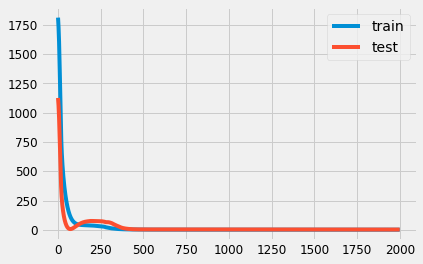

In [140]:
# design network
# We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting adj close
# The input shape will be 1 time step with 22 features.
model = Sequential()
model.add(LSTM(output_dim=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=2000, batch_size=72, validation_split=0.1, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [141]:
# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse = math.sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.566


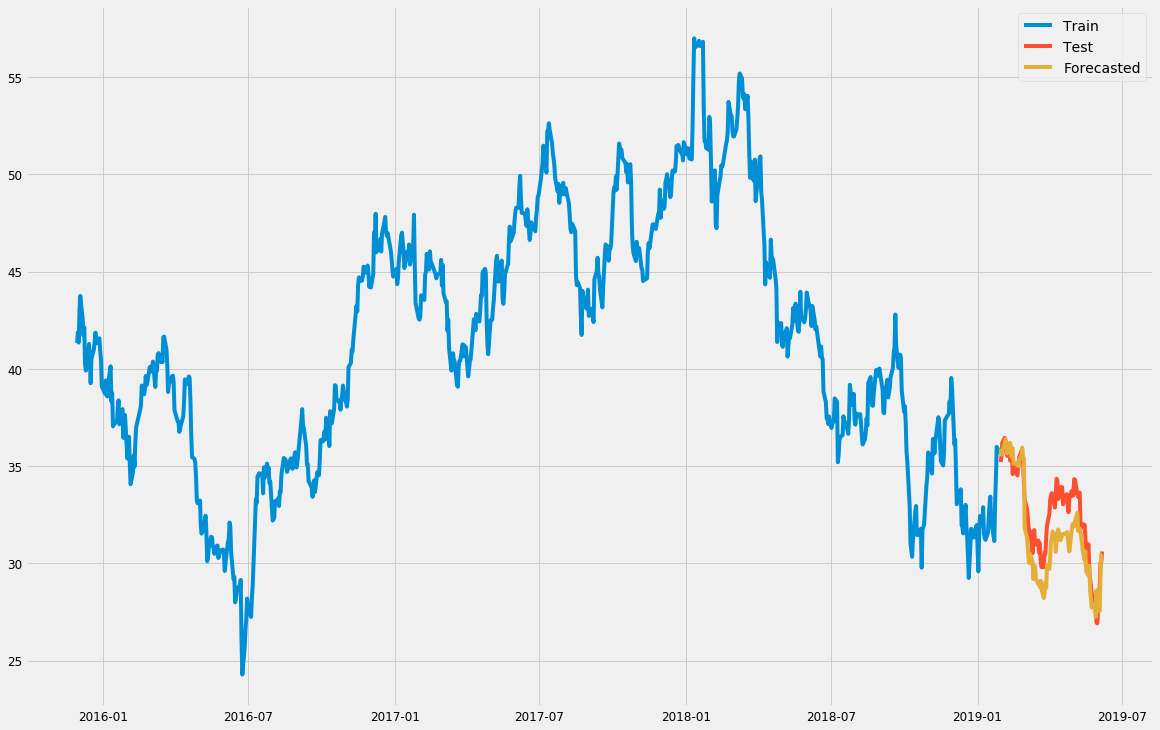

In [142]:
# show prediction vs actual value graph
df_ress = pd.DataFrame({'date':df_preds['Timestamp'][:-1],
                       'actual':np.append(train_y,test_y),
                       'model':np.append(train_y,yhat)})
df_ress = df_ress.set_index('date')

fig, ax = plt.subplots(figsize=(18,12))
plt.plot(df_ress['actual'][:n_train],label='Train')
plt.plot(df_ress['actual'][n_train:],label='Test')
plt.plot(df_ress['model'][n_train:],label='Forecasted')
plt.legend()
plt.show()

In [194]:
# df_ress.to_csv('appdata/df_ress.csv')

# Phase 1

## create COVID-19 timeline

In [62]:
df_covid = pd.read_csv('covid_timeline.csv')
df_covid = df_covid[['Timestamp','event']]
df_covid

,Timestamp,event
0,2019-12-08,"Wuhan city, China’s first case"
1,2019-12-31,WHO informed
2,2020-01-01,WHO emergency footing
3,2020-01-04,WHO reports cluster of cases
4,2020-01-07,china identifies novel coronavirus
5,2020-01-11,first death reported
6,2020-01-13,first case outside China
7,2020-01-14,WHO warns human-to-human transimssion
8,2020-01-20,virus spreads to US
9,2020-01-23,lockdown begins in china


## Analyze SDG scores change

### use data in SDG.csv

In [154]:
SDG_cv = SDG[SDG['Timestamp']>=min(df_covid['Timestamp'])]
# create a new df, whose 'Timestamp' column contains the dates after 2019-12-08
df_SDG_cv = pd.DataFrame({'Timestamp':SDG_cv[SDG_cv['Ticker']==SDG_cv['Ticker'].iloc[0]]['Timestamp']})
# reset the index, make it start from 0
df_SDG_cv = df_SDG_cv.reset_index(drop=True)
# calculate SDG scores by sector
# value in sct_1, timestamp='2019-12-12' reflects all sector 1 companies' avg SDG_mean score at '2019-12-12'
sector = list(set(SDG['GICS Sector']))
for i in range(len(sector)):
    # select sector i's data, groupby timestamp, for each date, we have SDG score of sector i's companies
    # calculate mean of SDG_mean of all companies belonging to sector i
    grouped = SDG_cv[SDG_cv['GICS Sector']==sector[i]].groupby('Timestamp')
    df_SDG_cv['sct_'+str(i+1)] = grouped['SDG_Mean'].agg(np.mean).reset_index(drop=True)

# calculate SDG scores by SDG class
# value in SDG_1, timestamp='2019-12-12' reflects avg value of all companies' SDG_1 score at '2019-12-12'
for i in range(17):
    grouped = SDG_cv.groupby('Timestamp')
    df_SDG_cv['SDG_'+str(i+1)] = grouped['SDG_'+str(i+1)].agg(np.mean).reset_index(drop=True)
# calculate SDG scores, overall
# this value is the avg of SDG_1, ... SDG_17 values of each day
df_SDG_cv['overall'] = df_SDG_cv.loc[:,'SDG_1':'SDG_17'].mean(axis=1)

In [157]:
df_SDG_cv

,Timestamp,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,...,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,overall
0,2019-12-08,0.482980,0.620638,-0.516249,0.586264,0.344352,0.573394,0.205434,0.855957,-0.259330,...,-0.335436,0.093340,0.123617,-0.217878,-0.566019,-0.226821,-0.363058,-0.329655,-0.597035,-0.260552
1,2019-12-09,0.847204,0.215247,0.360915,0.422226,1.357153,1.297084,0.649327,0.777804,-0.000871,...,0.190081,0.391826,0.420328,0.066168,-0.120496,0.129622,-0.209958,0.050593,-0.176397,0.167699
2,2019-12-10,0.230803,0.347609,0.091838,0.606638,1.055780,0.346452,0.141109,0.790865,-0.368686,...,0.120309,0.314023,0.287023,0.251459,-0.161280,0.224301,-0.156628,-0.235515,-0.148544,0.035909
3,2019-12-11,0.608284,0.807449,-0.043502,0.946897,1.572879,1.514490,0.720692,1.145525,0.347982,...,0.457016,0.534706,0.720534,0.494528,0.208786,0.400949,0.378322,0.107237,0.254345,0.404519
4,2019-12-12,0.824709,0.487517,0.371111,0.575904,1.713102,0.248436,0.734620,1.132636,-0.353700,...,0.575668,0.677145,0.714510,0.315131,0.060884,0.498964,0.234444,0.169643,0.530361,0.432705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2020-04-18,-0.598248,-0.823551,-0.875261,-0.750951,-0.479064,0.317696,-0.329554,0.022742,-2.028058,...,-0.797236,-0.774916,-0.644961,-1.029094,-1.436010,-1.228672,-1.329072,-1.003625,-0.880717,-1.021655
133,2020-04-19,-1.034393,-1.429272,-1.042465,-1.170493,-0.852451,-0.252670,-0.822333,-0.142735,-2.048628,...,-1.317657,-1.236383,-1.011200,-1.482959,-1.461890,-1.493103,-1.517502,-1.414180,-1.383538,-1.225420
134,2020-04-20,-0.567666,-0.757246,-0.568614,-0.836654,0.043563,-0.140783,-0.233595,0.027557,-1.611036,...,-0.867003,-0.653179,-0.461106,-0.997583,-1.092960,-1.229042,-1.136310,-0.902197,-0.741781,-0.768527
135,2020-04-21,-0.316513,0.065547,-0.222545,-0.574025,0.454924,0.276171,-0.133769,0.286001,-2.047783,...,-0.785233,-0.426794,-0.267726,-0.665814,-1.030007,-1.417788,-1.116590,-0.648104,-0.448148,-0.724249


In [195]:
# df_SDG_cv.to_csv("appdata/df_SDG_cv.csv")

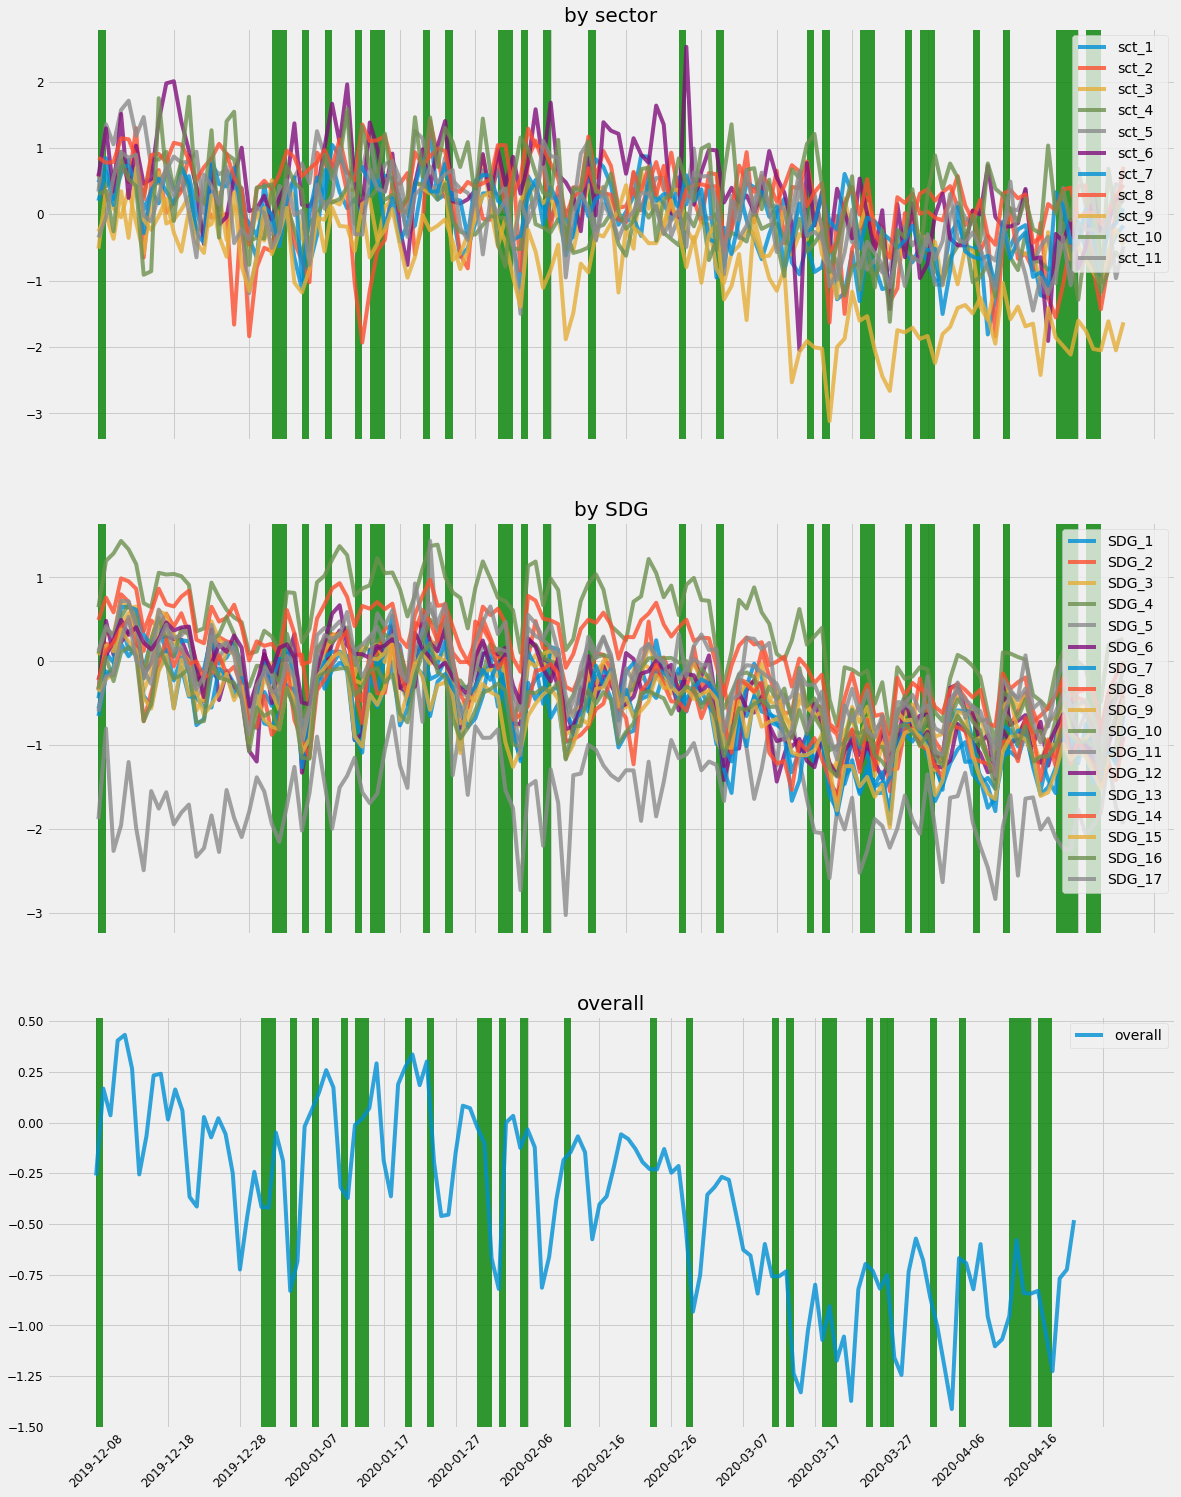

In [72]:
df_SDG_cv = df_SDG_cv.set_index('Timestamp')
df_bysector = df_SDG_cv.iloc[:,:11]
df_bysdg = df_SDG_cv.iloc[:,11:28]
df_overall = df_SDG_cv.iloc[:,28:]

#three graphs
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,24))

#plot lines
dfs = [df_bysector, df_bysdg, df_overall]
for i, df in enumerate(dfs):
    for v in df.columns.tolist():
        axes[i].plot(df[v], label=v, alpha=.8)
        axes[i].legend(loc="upper right")
        
def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df_covid['Timestamp'][i],str(pd.to_datetime(df_covid['Timestamp'][i])+datetime.timedelta(days=1))[:10],
                   facecolor='green', edgecolor='none', alpha=.8)
        i += 1

highlight_datetimes(df_covid['Timestamp'], axes[0])
highlight_datetimes(df_covid['Timestamp'], axes[1])
highlight_datetimes(df_covid['Timestamp'], axes[2])
axes[0].set_title('by sector', fontsize=20)
axes[1].set_title('by SDG', fontsize=20)
axes[2].set_title('overall', fontsize=20)
plt.xticks(np.linspace(0,150,16),rotation=45)
plt.show()

### use data in SDG_adj.csv

In [151]:
SDG_adj_cv = SDG_adj[SDG_adj['Timestamp']>=min(df_covid['Timestamp'])]
# create a new df, whose 'Timestamp' column contains the dates after 2019-12-08
df_SDG_adj_cv = pd.DataFrame({'Timestamp':SDG_adj_cv[SDG_adj_cv['Ticker']==SDG_adj_cv['Ticker'].iloc[0]]['Timestamp']})
# reset the index, make it start from 0
df_SDG_adj_cv = df_SDG_adj_cv.reset_index(drop=True)
# calculate SDG scores by sector
# value in sct_1, timestamp='2019-12-12' reflects all sector 1 companies' avg SDG_mean score at '2019-12-12'
sector = list(set(SDG_adj['GICS Sector']))
for i in range(len(sector)):
    # select sector i's data, groupby timestamp, for each date, we have SDG score of sector i's companies
    # calculate mean of SDG_mean of all companies belonging to sector i
    grouped = SDG_adj_cv[SDG_adj_cv['GICS Sector']==sector[i]].groupby('Timestamp')
    df_SDG_adj_cv['sct_'+str(i+1)] = grouped['SDG_Mean_ADJ'].agg(np.mean).reset_index(drop=True)

# calculate SDG scores by SDG class
# value in SDG_1, timestamp='2019-12-12' reflects avg value of all companies' SDG_1 score at '2019-12-12'
for i in range(17):
    grouped = SDG_adj_cv.groupby('Timestamp')
    df_SDG_adj_cv['SDG_'+str(i+1)+'_ADJ'] = grouped['SDG_'+str(i+1)+'_ADJ'].agg(np.mean).reset_index(drop=True)
# calculate SDG scores, overall
# this value is the avg of SDG_1, ... SDG_17 values of each day
df_SDG_adj_cv['overall'] = df_SDG_adj_cv.loc[:,'SDG_1_ADJ':'SDG_17_ADJ'].mean(axis=1)
df_SDG_adj_cv

,Timestamp,sct_1,sct_2,sct_3,sct_4,sct_5,sct_6,sct_7,sct_8,sct_9,...,SDG_9_ADJ,SDG_10_ADJ,SDG_11_ADJ,SDG_12_ADJ,SDG_13_ADJ,SDG_14_ADJ,SDG_15_ADJ,SDG_16_ADJ,SDG_17_ADJ,overall
0,2019-12-08,0.482980,0.620638,-0.516249,0.586264,0.344352,0.573394,0.205434,0.855957,-0.259330,...,-0.335436,0.093340,0.123617,-0.217878,-0.566019,-0.226821,-0.363058,-0.329655,-0.597035,-0.260552
1,2019-12-09,0.847204,0.215247,0.360915,0.422226,1.357153,1.297084,0.649327,0.777804,-0.000871,...,0.190081,0.391826,0.420328,0.066168,-0.120496,0.129622,-0.209958,0.050593,-0.176397,0.167699
2,2019-12-10,0.230803,0.347609,0.091838,0.606638,1.055780,0.346452,0.141109,0.790865,-0.368686,...,0.120309,0.314023,0.287023,0.251459,-0.161280,0.224301,-0.156628,-0.235515,-0.148544,0.035909
3,2019-12-11,0.608284,0.807449,-0.043502,0.946897,1.572879,1.514490,0.720692,1.145525,0.347982,...,0.457016,0.534706,0.720534,0.494528,0.208786,0.400949,0.378322,0.107237,0.254345,0.404519
4,2019-12-12,0.824709,0.487517,0.371111,0.575904,1.713102,0.248436,0.734620,1.132636,-0.353700,...,0.575668,0.677145,0.714510,0.315131,0.060884,0.498964,0.234444,0.169643,0.530361,0.432705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2020-04-18,-0.598248,-0.823551,-0.875261,-0.750951,-0.479064,0.317696,-0.329554,0.022742,-2.028058,...,-0.797236,-0.774916,-0.644961,-1.029094,-1.436010,-1.228672,-1.329072,-1.003625,-0.880717,-1.021655
133,2020-04-19,-1.034393,-1.429272,-1.042465,-1.170493,-0.852451,-0.252670,-0.822333,-0.142735,-2.048628,...,-1.317657,-1.236383,-1.011200,-1.482959,-1.461890,-1.493103,-1.517502,-1.414180,-1.383538,-1.225420
134,2020-04-20,-0.567666,-0.757246,-0.568614,-0.836654,0.043563,-0.140783,-0.233595,0.027557,-1.611036,...,-0.867003,-0.653179,-0.461106,-0.997583,-1.092960,-1.229042,-1.136310,-0.902197,-0.741781,-0.768527
135,2020-04-21,-0.316513,0.065547,-0.222545,-0.574025,0.454924,0.276171,-0.133769,0.286001,-2.047783,...,-0.785233,-0.426794,-0.267726,-0.665814,-1.030007,-1.417788,-1.116590,-0.648104,-0.448148,-0.724249


In [196]:
# df_SDG_adj_cv.to_csv('appdata/df_SDG_adj_cv.csv')

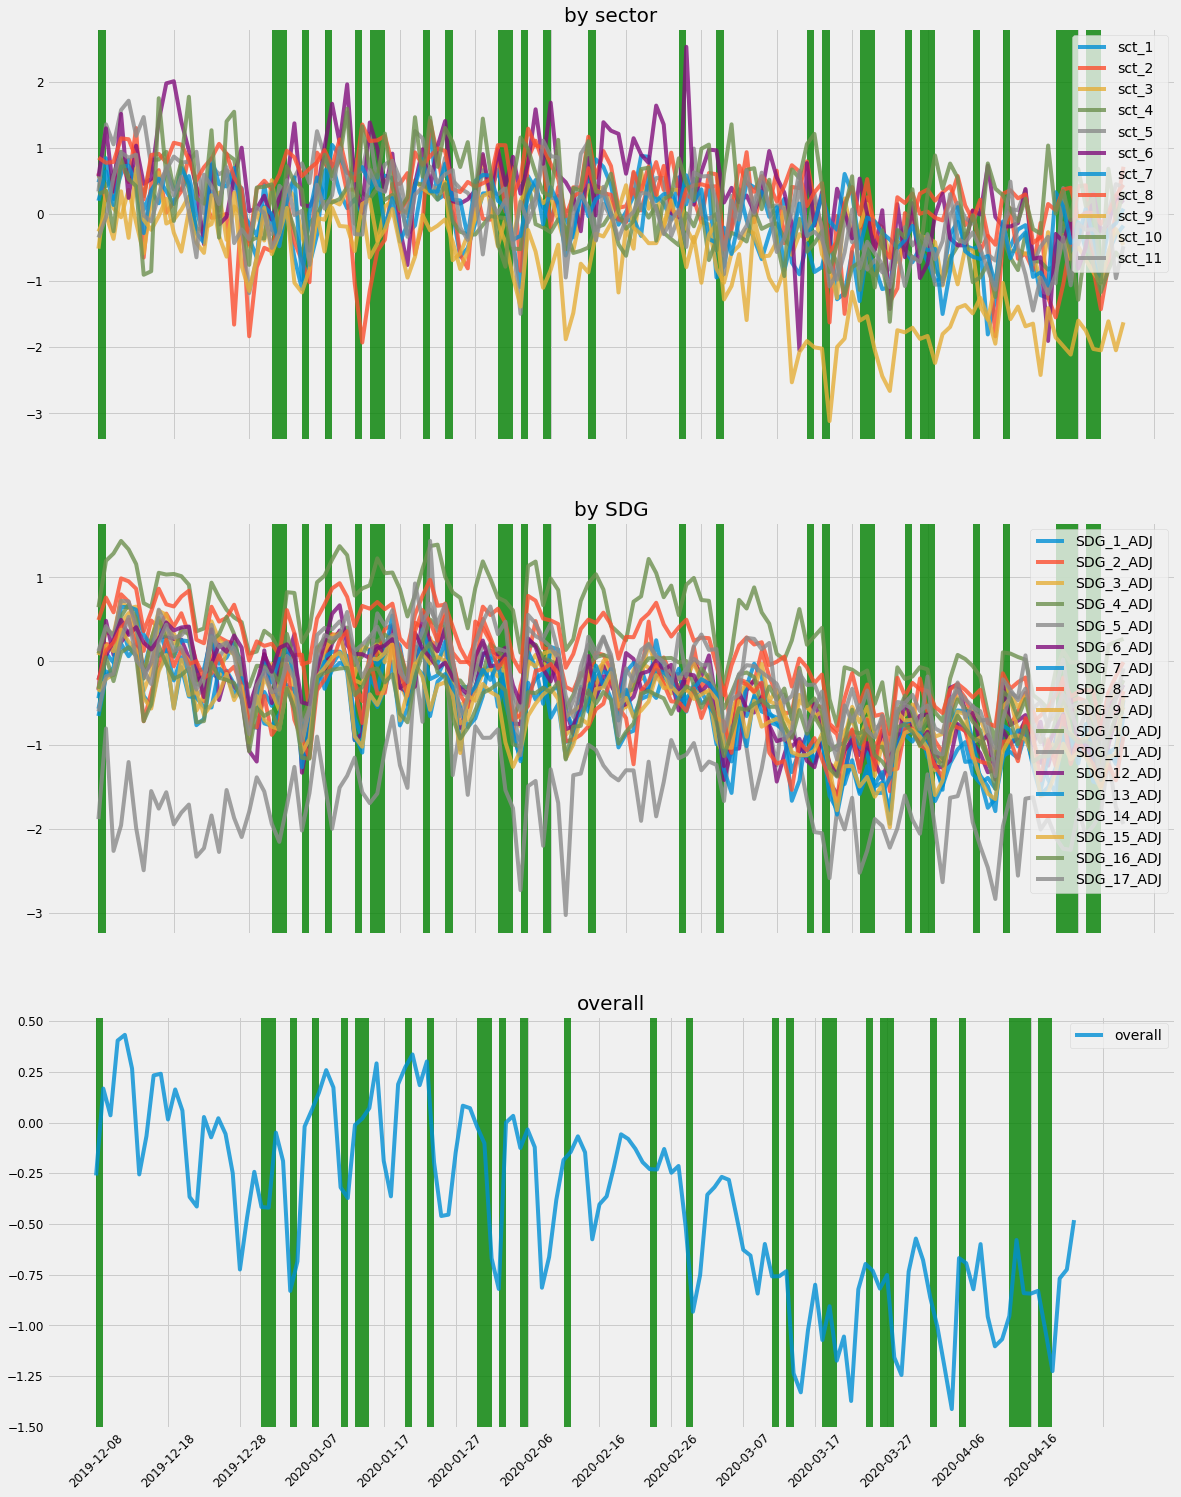

In [153]:
df_SDG_adj_cv = df_SDG_adj_cv.set_index('Timestamp')
df_adj_bysector = df_SDG_adj_cv.iloc[:,:11]
df_adj_bysdg = df_SDG_adj_cv.iloc[:,11:28]
df_adj_overall = df_SDG_adj_cv.iloc[:,28:]

#three graphs
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,24))

#plot lines
dfs = [df_adj_bysector, df_adj_bysdg, df_adj_overall]
for i, df in enumerate(dfs):
    for v in df.columns.tolist():
        axes[i].plot(df[v], label=v, alpha=.8)
        axes[i].legend(loc="upper right")
        
def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df_covid['Timestamp'][i],str(pd.to_datetime(df_covid['Timestamp'][i])+datetime.timedelta(days=1))[:10],
                   facecolor='green', edgecolor='none', alpha=.8)
        i += 1

highlight_datetimes(df_covid['Timestamp'], axes[0])
highlight_datetimes(df_covid['Timestamp'], axes[1])
highlight_datetimes(df_covid['Timestamp'], axes[2])
axes[0].set_title('by sector', fontsize=20)
axes[1].set_title('by SDG', fontsize=20)
axes[2].set_title('overall', fontsize=20)
plt.xticks(np.linspace(0,150,16),rotation=45)
plt.show()

# Phase2

## identify outlier

### use data in SDG.csv

In [211]:
# we use stock 'A' as an example to show our results
ticker_outbymean = 'A'
SDG_outbymean = SDG.loc[SDG['Ticker']==ticker_outbymean][['Ticker','Timestamp',
                                                          'SDG_Mean','SDG_STD_Mean','SDG_News_Volume_Mean']]
num0 = SDG_outbymean.shape[0]
SDG_outbymean.dropna(inplace=True)
num1 = SDG_outbymean.shape[0]

SDG_outbymean = SDG_outbymean.loc[SDG_outbymean['SDG_News_Volume_Mean'] >= 6]
num2 = SDG_outbymean.shape[0]

SDG_outbymean = SDG_outbymean.loc[(abs(SDG_outbymean['SDG_Mean'])/SDG_outbymean['SDG_STD_Mean'])>3]
num3 = SDG_outbymean.shape[0]

print('Selection criteria \t\t\t\t Percentage of dates remained\n')
print('drop NA \t\t\t\t\t '+"{:.2%}".format(num1/num0))
print('drop dates with News_Volume_Mean < 6 \t\t '+"{:.2%}".format(num2/num0))
print('select dates with score is pos/neg by 3 std \t '+"{:.2%}".format(num3/num0))
SDG_outbymean

Selection criteria 				 Percentage of dates remained

drop NA 					 79.80%
drop dates with News_Volume_Mean < 6 		 6.59%
select dates with score is pos/neg by 3 std 	 0.70%


,Ticker,Timestamp,SDG_Mean,SDG_STD_Mean,SDG_News_Volume_Mean
72,A,2013-06-12,-6.937054,0.333398,9.600000
142,A,2013-08-21,3.018150,0.314824,14.800000
584,A,2014-11-06,-1.199588,0.306548,6.333333
590,A,2014-11-12,-2.999396,0.291954,10.916667
748,A,2015-04-19,-3.848260,1.166100,8.200000
759,A,2015-04-30,2.980418,0.918665,7.250000
791,A,2015-06-01,-3.235866,1.053907,9.000000
834,A,2015-07-14,4.566370,1.194980,8.833333
992,A,2015-12-19,-3.136791,0.827609,6.727273
1226,A,2016-08-09,2.141434,0.051047,9.000000


In [109]:
t_outlier = time.time()
df_outlier = pd.DataFrame(columns=list(['Ticker','Timestamp','SDG_Mean','SDG_STD_Mean','SDG_News_Volume_Mean']))
for i in ctickers:
    SDG_outbymean = SDG.loc[SDG['Ticker']==i][['Ticker','Timestamp','SDG_Mean','SDG_STD_Mean','SDG_News_Volume_Mean']]
    SDG_outbymean.dropna(inplace=True)
    SDG_outbymean = SDG_outbymean.loc[SDG_outbymean['SDG_News_Volume_Mean'] >= 6]
    SDG_outbymean = SDG_outbymean.loc[(abs(SDG_outbymean['SDG_Mean'])/SDG_outbymean['SDG_STD_Mean'])>3]
    df_outlier = pd.concat((df_outlier,SDG_outbymean),axis=0)
print(time.time()-t_outlier)

60.419447898864746


In [110]:
df_outlier

,Ticker,Timestamp,SDG_Mean,SDG_STD_Mean,SDG_News_Volume_Mean
24769,ALV,2013-07-16,-4.640957,0.803461,11.600000
24841,ALV,2013-09-26,-4.908094,0.551853,9.500000
24855,ALV,2013-10-10,-2.346663,0.129800,8.000000
24897,ALV,2013-11-21,-1.993213,0.133236,14.000000
24902,ALV,2013-11-26,-0.910779,0.160953,7.000000
...,...,...,...,...,...
50952,REGN,2019-11-16,-3.710373,0.845254,9.444444
63387,FTI,2014-12-09,4.507867,0.065823,6.500000
63931,FTI,2016-06-05,-1.242851,0.306914,6.416667
64876,FTI,2019-01-06,2.372187,0.102878,8.000000


In [197]:
# df_outlier.to_csv('appdata/df_outlier.csv')

### use data in SDG_adj.csv

In [164]:
t_adj_outlier = time.time()
df_adj_outlier = pd.DataFrame(columns=list(['Ticker','Timestamp','SDG_Mean_ADJ','SDG_STD_Mean','SDG_News_Volume_Mean']))
for i in ctickers:
    SDG_adj_outbymean = SDG_adj.loc[SDG_adj['Ticker']==i][['Ticker','Timestamp','SDG_Mean_ADJ','SDG_STD_Mean','SDG_News_Volume_Mean']]
    SDG_adj_outbymean.dropna(inplace=True)
    SDG_adj_outbymean = SDG_adj_outbymean.loc[SDG_adj_outbymean['SDG_News_Volume_Mean'] >= 6]
    SDG_adj_outbymean = SDG_adj_outbymean.loc[(abs(SDG_adj_outbymean['SDG_Mean_ADJ'])/SDG_adj_outbymean['SDG_STD_Mean'])>3]
    df_adj_outlier = pd.concat((df_adj_outlier,SDG_adj_outbymean),axis=0)
print(time.time()-t_adj_outlier)

130.18772196769714


In [165]:
df_adj_outlier

,Ticker,Timestamp,SDG_Mean_ADJ,SDG_STD_Mean,SDG_News_Volume_Mean
24769,ALV,2013-07-16,-4.640957,0.803461,11.600000
24841,ALV,2013-09-26,-4.908094,0.551853,9.500000
24855,ALV,2013-10-10,-2.346663,0.129800,8.000000
24897,ALV,2013-11-21,-1.993213,0.133236,14.000000
24902,ALV,2013-11-26,-0.910779,0.160953,7.000000
...,...,...,...,...,...
50952,REGN,2019-11-16,-3.710373,0.845254,9.444444
63387,FTI,2014-12-09,4.507867,0.065823,6.500000
63931,FTI,2016-06-05,-1.242851,0.306914,6.416667
64876,FTI,2019-01-06,2.372187,0.102878,8.000000


In [198]:
# df_adj_outlier.to_csv('appdata/df_adj_outlier.csv')

### use data in sentiment.csv

In [173]:
t_stm_outlier = time.time()
df_stm_outlier = pd.DataFrame(columns=list(['Ticker','Timestamp','Sentiment','Sentiment_STD','Sentiment_News_Volume']))
for i in ctickers:
    stm_outbymean = sentiment.loc[sentiment['Ticker']==i][['Ticker','Timestamp','Sentiment','Sentiment_STD','Sentiment_News_Volume']]
    stm_outbymean.dropna(inplace=True)
    stm_outbymean = stm_outbymean.loc[stm_outbymean['Sentiment_News_Volume'] >= 6]
    stm_outbymean = stm_outbymean.loc[(abs(stm_outbymean['Sentiment'])/stm_outbymean['Sentiment_STD'])>3]
    df_stm_outlier = pd.concat((df_stm_outlier,stm_outbymean),axis=0)
print(time.time()-t_stm_outlier)

144.2060935497284


In [175]:
df_stm_outlier

,Ticker,Timestamp,Sentiment,Sentiment_STD,Sentiment_News_Volume
172899,ALV,2013-07-16,-3.737211,1.152818,23.0
172935,ALV,2013-08-21,0.247856,0.055717,6.0
172971,ALV,2013-09-26,-4.669027,0.699005,12.0
172985,ALV,2013-10-10,-2.346663,0.129800,8.0
173027,ALV,2013-11-21,-2.017034,0.213727,16.0
...,...,...,...,...,...
414691,FTI,2018-01-08,3.186580,0.546298,6.0
414849,FTI,2018-06-15,3.138180,0.789236,7.0
415054,FTI,2019-01-06,2.372187,0.102878,8.0
415104,FTI,2019-02-25,-3.425547,0.183827,13.0


In [199]:
# df_stm_outlier.to_csv('appdata/df_stm_outlier.csv')

## rank stock changes at key dates & select top 10 stocks

### use data in SDG.csv

In [35]:
# we rank stocks by the change of SDG_Mean
# first we select stock date from date '2019-12-07' to '2020-04-22', then calculate change of SDG_Mean and dropna
start_dat = str(pd.to_datetime(min(df_covid['Timestamp']))-datetime.timedelta(days=1))[:10]
SDG_rank_chg = SDG.loc[SDG['Timestamp']>=start_dat][['Timestamp','Ticker','SDG_Mean']]
SDG_rank_chg['SDG_Mean_Chg'] = SDG_rank_chg['SDG_Mean'].diff()
SDG_rank_chg.dropna(inplace=True)
SDG_rank_chg

,Timestamp,Ticker,SDG_Mean,SDG_Mean_Chg
2444,2019-12-10,A,0.831207,0.268346
2445,2019-12-11,A,0.067603,-0.763604
2446,2019-12-12,A,-0.803859,-0.871461
2447,2019-12-13,A,1.383505,2.187364
2448,2019-12-14,A,0.009566,-1.373939
...,...,...,...,...
9214,2020-03-27,ZTS,0.543478,-0.543478
9226,2020-04-08,ZTS,0.000000,0.000000
9234,2020-04-16,ZTS,1.282847,1.282847
9235,2020-04-17,ZTS,0.730419,-0.552428


In [37]:
# we create a new dataframe df_SDG_rank to store the rank results, set its timestamp same as that in df_covid
df_SDG_rank = pd.DataFrame(columns=['Timestamp','rank_1','rank_2','rank_3','rank_4','rank_5',
                                    'rank_6','rank_7','rank_8','rank_9','rank_10'])
df_SDG_rank['Timestamp'] = df_covid['Timestamp']
df_SDG_rank = df_SDG_rank.set_index('Timestamp')

# for each key date in COVID-19 timeline, we rank stocks by SDG_Mean_Chg, and take top 10 stocks
for i in df_SDG_rank.index:
    SDG_i = SDG_rank_chg.loc[SDG_rank_chg['Timestamp'] == i]
    top_ten = SDG_i.sort_values('SDG_Mean_Chg',ascending=False)[['Ticker']][:10]
    df_SDG_rank.loc[i] = top_ten.T.values
df_SDG_rank

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
Timestamp,,,,,,,,,,
2019-12-08,MTB,VER,RCL,GME,VRTX,ATO,WAB,ACGL,HAL,ES
2019-12-31,HLT,TSCO,NKE,SYMC,DAL,FDC,ANSS,HPQ,KMI,DATA
2020-01-01,DXC,VFC,AFL,FAST,LULU,BAX,NOV,MAT,INTU,OC
2020-01-04,GME,AFL,AME,IP,TIF,ECL,RCL,ETFC,CNC,DATA
2020-01-07,LB,CSGP,HBAN,TFX,FISV,PCAR,DRI,LYB,ISRG,IR
2020-01-11,STI,DG,ACGL,AGCO,STZ,SBNY,BG,PANW,PEG,DE
2020-01-13,LM,HAL,IP,CPB,PII,GE,AMTD,JWN,JNPR,TSLA
2020-01-14,HSIC,DOV,MHK,TRU,INFO,AKAM,DG,FL,SO,CCL
2020-01-20,WAB,GME,SO,EIX,ACGL,ABC,DLTR,K,ARMK,PEP


In [200]:
# df_SDG_rank.to_csv('appdata/df_SDG_rank.csv')

### use data in SDG_adj.csv

In [178]:
# we rank stocks by the change of SDG_Mean
# first we select stock date from date '2019-12-07' to '2020-04-22', then calculate change of SDG_Mean and dropna
start_dat = str(pd.to_datetime(min(df_covid['Timestamp']))-datetime.timedelta(days=1))[:10]
SDG_adj_rank_chg = SDG_adj.loc[SDG_adj['Timestamp']>=start_dat][['Timestamp','Ticker','SDG_Mean_ADJ']]
SDG_adj_rank_chg['SDG_Mean_ADJ_Chg'] = SDG_adj_rank_chg['SDG_Mean_ADJ'].diff()
SDG_adj_rank_chg.dropna(inplace=True)
SDG_adj_rank_chg

,Timestamp,Ticker,SDG_Mean_ADJ,SDG_Mean_ADJ_Chg
2444,2019-12-10,A,0.831207,0.268346
2445,2019-12-11,A,0.067603,-0.763604
2446,2019-12-12,A,-0.803859,-0.871461
2447,2019-12-13,A,1.383505,2.187364
2448,2019-12-14,A,0.009566,-1.373939
...,...,...,...,...
9214,2020-03-27,ZTS,0.543478,-0.543478
9226,2020-04-08,ZTS,0.000000,0.000000
9234,2020-04-16,ZTS,1.282847,1.282847
9235,2020-04-17,ZTS,0.730419,-0.552428


In [179]:
# we create a new dataframe df_SDG_rank to store the rank results, set its timestamp same as that in df_covid
df_SDG_adj_rank = pd.DataFrame(columns=['Timestamp','rank_1','rank_2','rank_3','rank_4','rank_5',
                                    'rank_6','rank_7','rank_8','rank_9','rank_10'])
df_SDG_adj_rank['Timestamp'] = df_covid['Timestamp']
df_SDG_adj_rank = df_SDG_adj_rank.set_index('Timestamp')

# for each key date in COVID-19 timeline, we rank stocks by SDG_Mean_Chg, and take top 10 stocks
for i in df_SDG_adj_rank.index:
    SDG_adj_i = SDG_adj_rank_chg.loc[SDG_adj_rank_chg['Timestamp'] == i]
    adj_top_ten = SDG_adj_i.sort_values('SDG_Mean_ADJ_Chg',ascending=False)[['Ticker']][:10]
    df_SDG_adj_rank.loc[i] = adj_top_ten.T.values
df_SDG_adj_rank

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
Timestamp,,,,,,,,,,
2019-12-08,MTB,VER,RCL,GME,VRTX,ATO,WAB,ACGL,HAL,ES
2019-12-31,HLT,TSCO,NKE,SYMC,DAL,FDC,ANSS,HPQ,KMI,DATA
2020-01-01,DXC,VFC,AFL,FAST,LULU,BAX,NOV,MAT,INTU,OC
2020-01-04,GME,AFL,AME,IP,TIF,ECL,RCL,ETFC,CNC,DATA
2020-01-07,LB,CSGP,HBAN,TFX,FISV,PCAR,DRI,LYB,ISRG,IR
2020-01-11,STI,DG,ACGL,AGCO,STZ,SBNY,BG,PANW,PEG,DE
2020-01-13,LM,HAL,IP,CPB,PII,GE,AMTD,JWN,JNPR,TSLA
2020-01-14,HSIC,DOV,MHK,TRU,INFO,AKAM,DG,FL,SO,CCL
2020-01-20,WAB,GME,SO,EIX,ACGL,ABC,DLTR,K,ARMK,PEP


In [201]:
# df_SDG_adj_rank.to_csv('appdata/df_SDG_adj_rank.csv')

### use data in sentiment.csv

In [181]:
# we rank stocks by the change of SDG_Mean
# first we select stock date from date '2019-12-07' to '2020-04-22', then calculate change of SDG_Mean and dropna
start_dat = str(pd.to_datetime(min(df_covid['Timestamp']))-datetime.timedelta(days=1))[:10]
stm_rank_chg = sentiment.loc[sentiment['Timestamp']>=start_dat][['Timestamp','Ticker','Sentiment']]
stm_rank_chg['Sentiment_Chg'] = stm_rank_chg['Sentiment'].diff()
stm_rank_chg.dropna(inplace=True)
stm_rank_chg

,Timestamp,Ticker,Sentiment,Sentiment_Chg
5020,2019-12-07,ABT,2.275442,0.776588
5021,2019-12-08,ABT,-0.960124,-3.235565
5022,2019-12-09,ABT,-0.015243,0.944881
5023,2019-12-10,ABT,0.159462,0.174705
5024,2019-12-11,ABT,0.656738,0.497276
...,...,...,...,...
154422,2020-04-09,ZTS,1.177856,1.177856
154429,2020-04-16,ZTS,1.282847,0.476395
154430,2020-04-17,ZTS,0.775202,-0.507645
154434,2020-04-21,ZTS,0.000000,0.000000


In [182]:
# we create a new dataframe df_SDG_rank to store the rank results, set its timestamp same as that in df_covid
df_stm_rank = pd.DataFrame(columns=['Timestamp','rank_1','rank_2','rank_3','rank_4','rank_5',
                                    'rank_6','rank_7','rank_8','rank_9','rank_10'])
df_stm_rank['Timestamp'] = df_covid['Timestamp']
df_stm_rank = df_stm_rank.set_index('Timestamp')

# for each key date in COVID-19 timeline, we rank stocks by SDG_Mean_Chg, and take top 10 stocks
for i in df_stm_rank.index:
    stm_i = stm_rank_chg.loc[stm_rank_chg['Timestamp'] == i]
    stm_top_ten = stm_i.sort_values('Sentiment_Chg',ascending=False)[['Ticker']][:10]
    df_stm_rank.loc[i] = stm_top_ten.T.values
df_stm_rank

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
Timestamp,,,,,,,,,,
2019-12-08,MTB,VER,ATO,COMM,WAB,VRTX,CSX,AET,ACGL,VRSK
2019-12-31,HLT,TSCO,NOW,ZBH,EXC,FDC,NCLH,KMI,URI,AVY
2020-01-01,DXC,AFL,KMB,CNP,CLX,BG,LULU,ATO,FAST,AKAM
2020-01-04,ECL,AFL,RCL,ETFC,AZO,S,LNC,IP,AME,JBHT
2020-01-07,ECL,LB,AIZ,HBAN,PCAR,NKE,LEA,TFX,ISRG,A
2020-01-11,JBHT,STI,STZ,ACGL,SBNY,AGCO,KLAC,UGI,AGN,VRSN
2020-01-13,CBS,HAL,CINF,CDNS,LM,AFL,PII,GE,JLL,IP
2020-01-14,HSIC,MHK,TRU,DOV,INFO,XYL,DG,SO,VRTX,MTB
2020-01-20,K,EIX,RCL,ACGL,ROST,ABC,SO,MCK,ARMK,NTRS


In [202]:
# df_stm_rank.to_csv('appdata/df_stm_rank.csv')

## show graphs of major companies per sector

### use data in SDG.csv

In [38]:
# the major companies we select for the 11 sectors are as follows

# communication services: FB
# consumer discretionary: AMZN
# consumer staples: WMT
# energy: XOM
# financials: GS
# health care: CVS
# industrials: GE
# information technology: AAPL
# materials: ECL
# real estate: AMT
# utilities:NEE

In [39]:
major_ticker = ['FB','AMZN','WMT','XOM','GS','CVS','GE','AAPL','ECL','AMT','NEE']
SDG_maj = SDG_rank_chg[SDG_rank_chg['Ticker'].isin(major_ticker)]
SDG_maj

,Timestamp,Ticker,SDG_Mean,SDG_Mean_Chg
10179,2019-12-08,AAPL,0.099695,0.213242
10180,2019-12-09,AAPL,-0.180816,-0.280510
10181,2019-12-10,AAPL,-0.878654,-0.697838
10182,2019-12-11,AAPL,0.076444,0.955097
10183,2019-12-12,AAPL,-0.289324,-0.365767
...,...,...,...,...
48323,2020-04-18,XOM,-2.866213,-0.521586
48324,2020-04-19,XOM,-3.270775,-0.404562
48325,2020-04-20,XOM,-2.804528,0.466247
48326,2020-04-21,XOM,-2.668418,0.136110


In [203]:
# SDG_maj.to_csv('appdata/SDG_maj.csv')

<function matplotlib.pyplot.show(*args, **kw)>

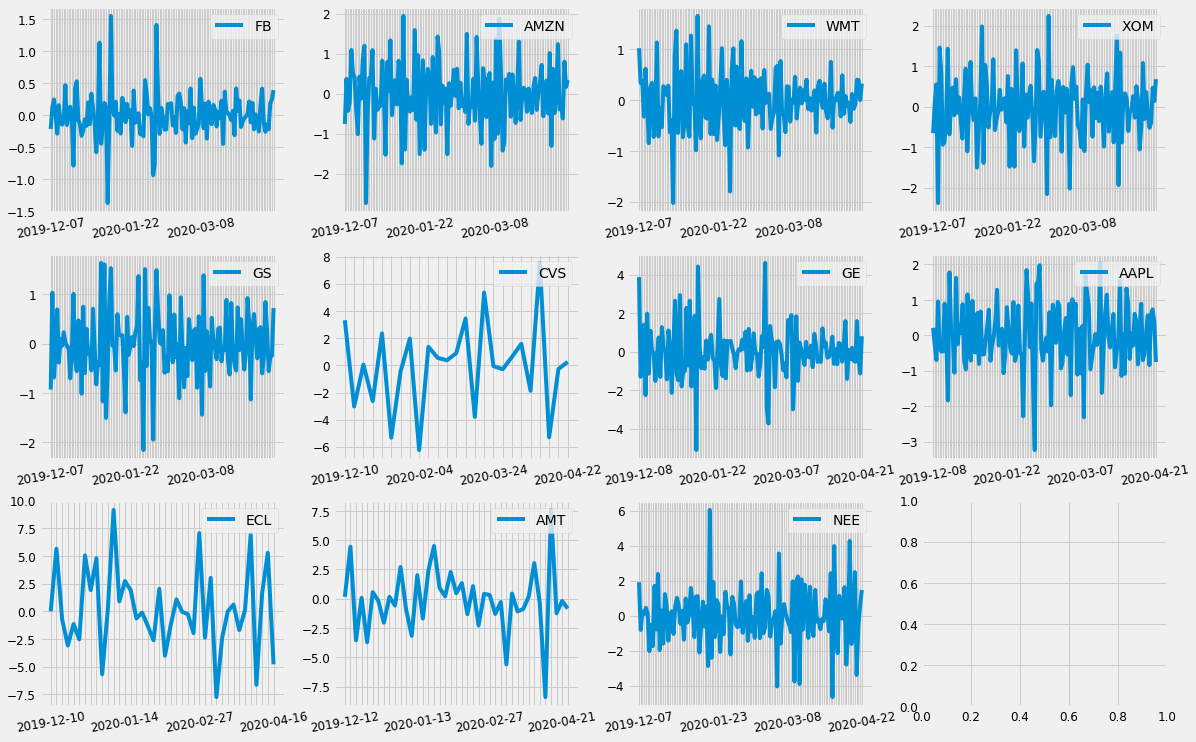

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, figsize=(18,12))
for i in range(len(major_ticker)):
    
    df_axe = SDG_maj[SDG_maj['Ticker']==major_ticker[i]][['Timestamp','SDG_Mean_Chg']].set_index('Timestamp')
    #ticklabels: the date labels for xaxis, 'num' is the number of date labels in each subplot
    ticklabels = ['']*len(df_axe.index)
    num = int(len(df_axe.index)/3)
    ticklabels[::num] = [item for item in df_axe.index[::num]]
    
    row,col = divmod(i,axes.shape[1])
    axes[row][col].plot(df_axe['SDG_Mean_Chg'],label=major_ticker[i])
    axes[row][col].legend(loc="upper right")
    axes[row][col].xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
    plt.setp(axes[row][col].get_xticklabels(), rotation=10)

plt.show

### use data in SDG_adj.csv

In [186]:
major_ticker = ['FB','AMZN','WMT','XOM','GS','CVS','GE','AAPL','ECL','AMT','NEE']
SDG_adj_maj = SDG_adj_rank_chg[SDG_adj_rank_chg['Ticker'].isin(major_ticker)]
SDG_adj_maj

,Timestamp,Ticker,SDG_Mean_ADJ,SDG_Mean_ADJ_Chg
10179,2019-12-08,AAPL,0.099695,0.213242
10180,2019-12-09,AAPL,-0.180816,-0.280510
10181,2019-12-10,AAPL,-0.878654,-0.697838
10182,2019-12-11,AAPL,0.076444,0.955097
10183,2019-12-12,AAPL,-0.289324,-0.365767
...,...,...,...,...
48323,2020-04-18,XOM,-2.866213,-0.521586
48324,2020-04-19,XOM,-3.270775,-0.404562
48325,2020-04-20,XOM,-2.804528,0.466247
48326,2020-04-21,XOM,-2.668418,0.136110


In [204]:
# SDG_adj_maj.to_csv('appdata/SDG_adj_maj.csv')

<function matplotlib.pyplot.show(*args, **kw)>

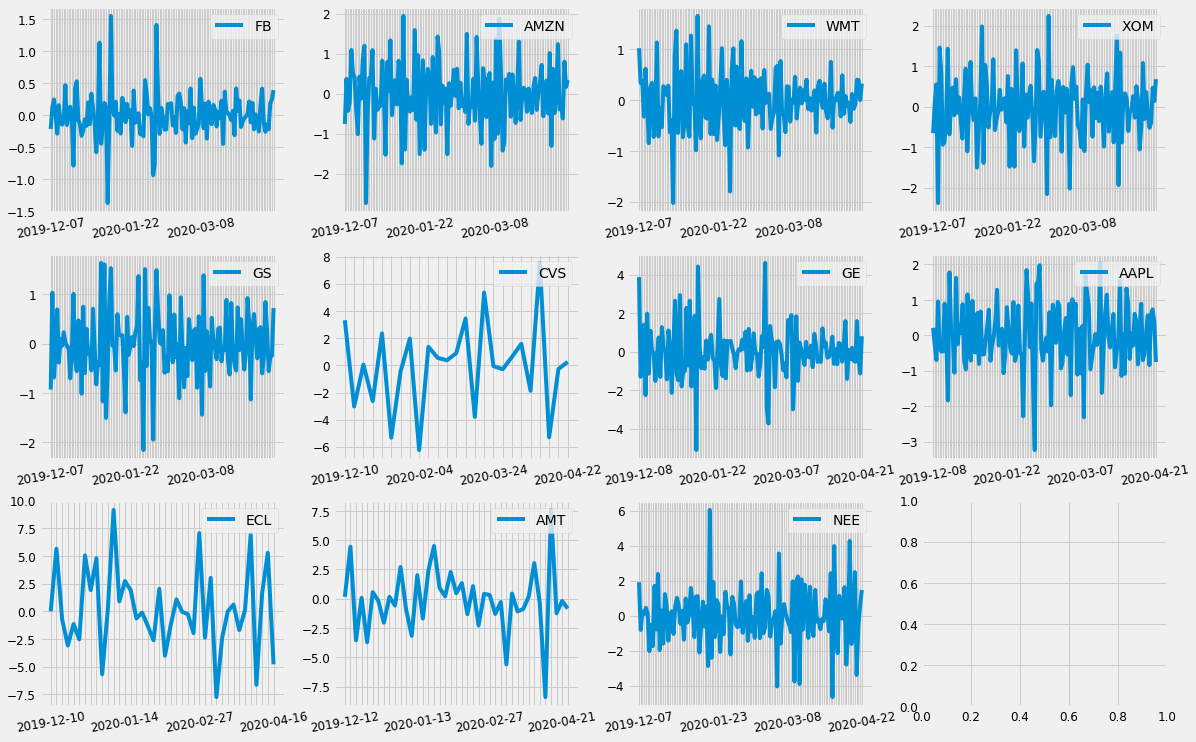

In [188]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, figsize=(18,12))
for i in range(len(major_ticker)):
    
    df_axe = SDG_adj_maj[SDG_adj_maj['Ticker']==major_ticker[i]][['Timestamp','SDG_Mean_ADJ_Chg']].set_index('Timestamp')
    #ticklabels: the date labels for xaxis, 'num' is the number of date labels in each subplot
    ticklabels = ['']*len(df_axe.index)
    num = int(len(df_axe.index)/3)
    ticklabels[::num] = [item for item in df_axe.index[::num]]
    
    row,col = divmod(i,axes.shape[1])
    axes[row][col].plot(df_axe['SDG_Mean_ADJ_Chg'],label=major_ticker[i])
    axes[row][col].legend(loc="upper right")
    axes[row][col].xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
    plt.setp(axes[row][col].get_xticklabels(), rotation=10)

plt.show

### use data in sentiment.csv

In [189]:
major_ticker = ['FB','AMZN','WMT','XOM','GS','CVS','GE','AAPL','ECL','AMT','NEE']
stm_maj = stm_rank_chg[stm_rank_chg['Ticker'].isin(major_ticker)]
stm_maj

,Timestamp,Ticker,Sentiment,Sentiment_Chg
79811,2019-12-07,AMZN,0.786448,0.814718
79812,2019-12-08,AMZN,1.146108,0.359660
79813,2019-12-09,AMZN,-0.640450,-1.786558
79814,2019-12-10,AMZN,0.264717,0.905167
79815,2019-12-11,AMZN,1.320372,1.055656
...,...,...,...,...
74482,2020-04-18,WMT,-1.599043,0.232846
74483,2020-04-19,WMT,-1.334299,0.264744
74484,2020-04-20,WMT,-0.726464,0.607835
74485,2020-04-21,WMT,-0.866610,-0.140146


In [205]:
# stm_maj.to_csv('appdata/stm_maj.csv')

<function matplotlib.pyplot.show(*args, **kw)>

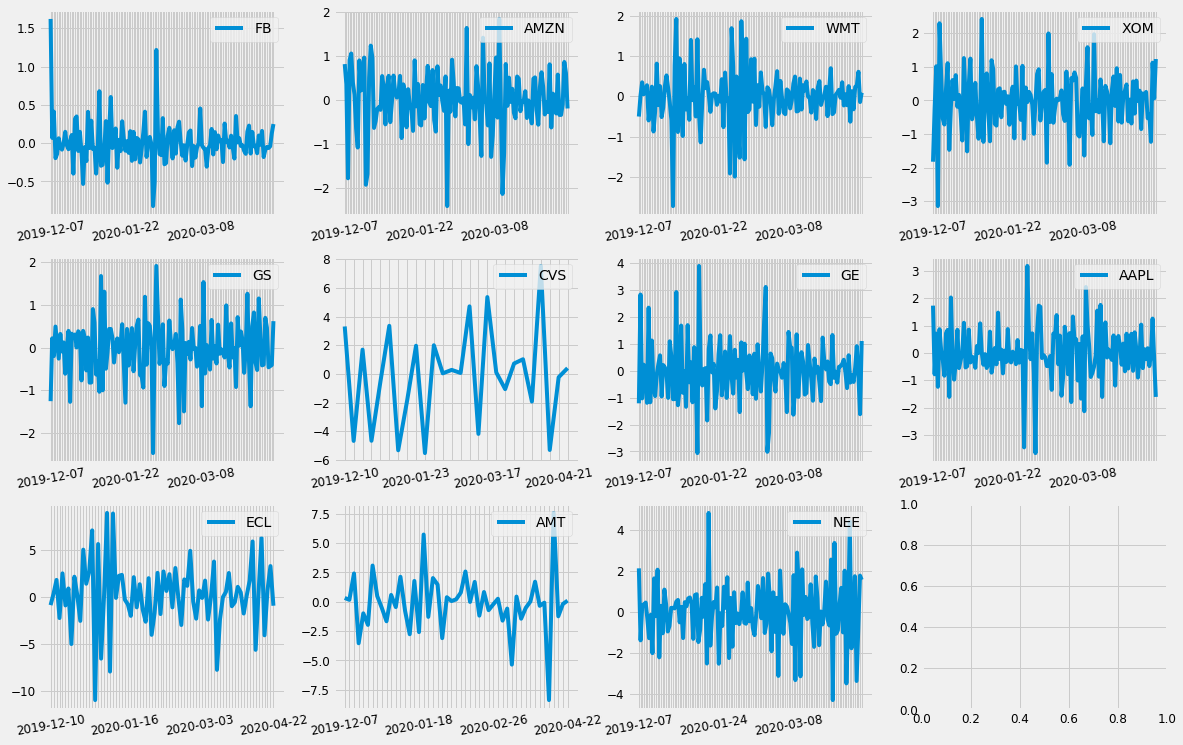

In [191]:
fig, axes = plt.subplots(nrows=3, ncols=4, sharex=False, figsize=(18,12))
for i in range(len(major_ticker)):
    
    df_axe = stm_maj[stm_maj['Ticker']==major_ticker[i]][['Timestamp','Sentiment_Chg']].set_index('Timestamp')
    #ticklabels: the date labels for xaxis, 'num' is the number of date labels in each subplot
    ticklabels = ['']*len(df_axe.index)
    num = int(len(df_axe.index)/3)
    ticklabels[::num] = [item for item in df_axe.index[::num]]
    
    row,col = divmod(i,axes.shape[1])
    axes[row][col].plot(df_axe['Sentiment_Chg'],label=major_ticker[i])
    axes[row][col].legend(loc="upper right")
    axes[row][col].xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(ticklabels))
    plt.setp(axes[row][col].get_xticklabels(), rotation=10)

plt.show